# <p style="background-color:#19415E;font-family:newtimeroman;color:#EFEFEE;font-size:150%;text-align:center;border-radius:10px 10px;">Ticket Volume Forecast</p>


_Cozentus PVT Limited (January 2024)_

Goal:

- Explore the data (ECDF, handle missing values etc).
- Analysis per store type and correlational analysis of stores activity.
- Perform extensive Time Series Analysis (seasonal decomposition, trends, autocorrelation).
- Predict next 6 weeks of sales using Prophet (Facebook methodology).


In this notebook, we will walk through the process of time series forecasting of Call Volume using the Prophet model. Time series forecasting is a critical task in various domains, from finance to supply chain management. We will perform the following steps:

1. Importing Library:

  To get started, we import the necessary Python libraries required for time series forecasting with the Prophet model. These libraries will enable us to manipulate and visualize time series data efficiently.

2. Loading and Splitting Required Clean Data:

  In this step, we load our time series data. We will also split the data into training and testing sets, ensuring that we have a portion of the data reserved for evaluating the model's performance.

3. Training Models on Whole Data:

  We begin by training our initial Prophet model on the entire dataset. This model will provide an overall forecast based on historical data.

4. Training New Categories with New Data Only:

  As new data becomes available, we train additional categories within our Prophet model. This allows us to continuously update our forecast to account for changing trends and patterns.

5. Data Visualization:

  Data visualization is a crucial aspect of time series forecasting. In this section, we create visualizations to better understand our time series data, historical trends, and the model's forecasts.

6. Testing Models Created on Whole Data:

  After training our initial Prophet model on the complete dataset, we assess its performance by testing it on the testing dataset. This evaluation helps us understand how well the model generalizes to unseen data.

7. Testing Models Trained on New Data:

  Similarly, we evaluate the performance of models trained on new data. This step is essential in assessing how well the model adapts to changing patterns and whether it continues to provide accurate forecasts as new data is incorporated.

By following the flow of this notebook, we aim to achieve accurate time series forecasts and maintain the model's effectiveness as new data arrives. Time series forecasting is vital for making informed decisions and predictions in various applications.

## 1. Importing Libraries

In [1]:
import os
import subprocess
import numpy as np
import plotly
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from prophet.serialize import model_to_json, model_from_json

## 2. Importing Data

In [2]:
full_file_path='/content/All tickets logged Dec 15 2023.xlsx'
dataset_original_ticket=pd.read_excel(full_file_path)

In [3]:
dataset_latest_ticket=dataset_original_ticket.copy()

## 3. Function Defination

In [4]:
def date_filler(df,date_col):
  date_range = pd.date_range(start=df[date_col].min(), end=df[date_col].max())

  # Create a new DataFrame with all dates and fill missing values with 0
  new_df = df.set_index(date_col).reindex(date_range).fillna(0)

  # Reset the index to obtain the final DataFrame
  new_df = new_df.reset_index()
  new_df.columns=[date_col]+list(new_df.columns[1:])
  return new_df

In [5]:
def save_model(model_name,file_name):
  with open(file_name, 'w') as fout:
    fout.write(model_to_json(model_name))  # Save model

In [6]:
def process_json_files(target_dir="newjson", zip_file_name="newjson.zip"):
    """
    Removes any existing directory and ZIP file, creates a new directory,
    copies JSON files into it, and creates a ZIP archive of the directory.

    Args:
        target_dir (str, optional): Name of the directory to create. Defaults to "newjson".
        zip_file_name (str, optional): Name of the ZIP file to create. Defaults to "newjson.zip".
    """

    os.system(f"rm -rf {target_dir} {zip_file_name}")  # Remove existing files/directories
    os.mkdir(target_dir)  # Create the target directory
    subprocess.run(["cp", "*.json", target_dir])  # Copy JSON files
    subprocess.run(["zip", "-r", zip_file_name, target_dir])  # Create ZIP archive

In [7]:
def load_model(model_path):
  with open(model_path, "r") as fin:
    model_json = fin.read()
  model = model_from_json(model_json)
  return model

## 4. Preprocessing Data

### 4.1 Common Preprocessing

In [8]:
dataset_latest_ticket['Call Date']=dataset_latest_ticket['Call Date'].dt.date

### 4.2 Base Model

In [9]:
dataset_pivot_daily_count=dataset_latest_ticket.groupby('Call Date')['Ticket Number'].count().fillna(0).reset_index()

In [10]:
dataset_pivot_daily_count=date_filler(dataset_pivot_daily_count,'Call Date')

In [11]:
dataset_pivot_daily_count.rename(columns={'Ticket Number':'all'},inplace=True)

In [12]:
train_ratio=0.8  #
row_counts_or_column_counts_accessor=0 #0 or 1
dataset_training_base=dataset_pivot_daily_count.iloc[:int(dataset_pivot_daily_count.shape[row_counts_or_column_counts_accessor]*train_ratio),:].copy()
dataset_testing_base=dataset_pivot_daily_count.iloc[int(dataset_pivot_daily_count.shape[row_counts_or_column_counts_accessor]*train_ratio):,:].copy()

In [13]:
dataset_training_base.reset_index(inplace=True)
dataset_testing_base.reset_index(inplace=True)

### 4.3 Category Wise Models

In [14]:
dataset_pivot_category_wise_daily_count=dataset_latest_ticket.pivot_table(columns=['Category'],index='Call Date',values='Ticket Number',aggfunc='count').fillna(0)

In [15]:
dataset_pivot_category_wise_daily_count.reset_index(inplace=True)
dataset_pivot_category_wise_daily_count=date_filler(dataset_pivot_category_wise_daily_count,'Call Date')

In [16]:
train_ratio=0.8
row_counts_or_column_counts_accessor=0 #0 or 1
dataset_training_category_wise=dataset_pivot_category_wise_daily_count.iloc[:int(\
        dataset_pivot_category_wise_daily_count.shape[row_counts_or_column_counts_accessor]*train_ratio),:].copy()
dataset_testing_category_wise=dataset_pivot_category_wise_daily_count.iloc[int(\
        dataset_pivot_category_wise_daily_count.shape[row_counts_or_column_counts_accessor]*train_ratio):,:].copy()

### 4.4 Priority Wise Models

In [17]:
dataset_pivot_priority_wise_daily_count=dataset_latest_ticket.pivot_table(columns=['Priority'],index='Call Date',values='Ticket Number',aggfunc='count').fillna(0)

In [18]:
dataset_pivot_priority_wise_daily_count.columns=['P1', 'P2', 'P3', 'P4', 'P6']

In [19]:
dataset_pivot_priority_wise_daily_count.reset_index(inplace=True)
dataset_pivot_priority_wise_daily_count=date_filler(dataset_pivot_priority_wise_daily_count,'Call Date')

In [20]:
train_ratio=0.8
row_counts_or_column_counts_accessor=0 #0 or 1
dataset_training_priority_wise=dataset_pivot_priority_wise_daily_count.iloc[:int(\
        dataset_pivot_priority_wise_daily_count.shape[row_counts_or_column_counts_accessor]*train_ratio),:].copy()
dataset_testing_priority_wise=dataset_pivot_priority_wise_daily_count.iloc[int(\
        dataset_pivot_priority_wise_daily_count.shape[row_counts_or_column_counts_accessor]*train_ratio):,:].copy()

### 4.5 Category-Priority Wise Models

In [21]:
dataset_pivot_priority_category_wise_daily_count=dataset_latest_ticket.pivot_table(\
        columns=['Category','Priority'],index='Call Date',values='Ticket Number',aggfunc='count').fillna(0)

In [22]:
dataset_pivot_priority_category_wise_daily_count.reset_index(inplace=True)
dataset_pivot_priority_category_wise_daily_count=date_filler(dataset_pivot_priority_category_wise_daily_count,'Call Date')

In [23]:
train_ratio=0.8
row_counts_or_column_counts_accessor=0 #0 or 1
dataset_training_priority_category_wise=dataset_pivot_priority_category_wise_daily_count.iloc[:int(\
        dataset_pivot_priority_category_wise_daily_count.shape[row_counts_or_column_counts_accessor]*train_ratio),:].copy()
dataset_testing_priority_category_wise=dataset_pivot_priority_category_wise_daily_count.iloc[int(\
        dataset_pivot_priority_category_wise_daily_count.shape[row_counts_or_column_counts_accessor]*train_ratio):,:].copy()

## 5. Data Visualisation

In [24]:
#Will Do it Later

## 6. Model Training and Saving

### 6.1 Base Model

In [25]:
for i in dataset_training_base.columns:
  if i not in ['Call Date', 'index' , 'DateYMD']:
    print(i)
    dataset_current=dataset_training_base[['Call Date',i]]
    dataset_current.columns=['ds','y']
    dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
    dataset_current['cap']=(dataset_current.y.max()*3)+1 #= 100
    dataset_current['floor']=0 #did not exist
    model_current = Prophet(growth='logistic')
    model_current.fit(dataset_current)
    # if i=='P6':
    #   priority_var=i
    # else:
    #   priority_var='P'+i
    priority_var='all'
    category_var='all'
    save_model(model_current,'category_'+category_var+'_priority_'+priority_var+'_model.json')
    # print(dataset_current.shape)
    print(i, ' Finished!')

all


<ipython-input-25-12d93724e755>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/_95mh8dc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/euz39gae.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41373', 'data', 'file=/tmp/tmpk6qx1nfi/_95mh8dc.json', 'init=/tmp/tmpk6qx1nfi/euz39gae.

all  Finished!


### 6.2 Category Wise Models

In [26]:
for i in dataset_training_category_wise.columns:
  if i not in ['Call Date', 'index' , 'DateYMD']:
    print(i)
    dataset_current=dataset_training_category_wise[['Call Date',i]]
    dataset_current.columns=['ds','y']
    dataset_current=date_filler(dataset_current,'ds')
    dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
    dataset_current['cap']=200 #; (df.y.max()*3)+1 #= 100
    dataset_current['floor']=0 #did not exist
    model_current = Prophet()
    model_current.fit(dataset_current)
    priority_var='all'
    # if i[1]=='P6':
    #   priority_var=i[1]
    # else:
    #   priority_var='P'+i[1]
    category_var=i
    save_model(model_current,'category_'+category_var+'_priority_'+priority_var+'_model.json')
    # print(df.shape)
    print(i, ' Finished!')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/86_fohy5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/3y2fgyy2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50178', 'data', 'file=/tmp/tmpk6qx1nfi/86_fohy5.json', 'init=/tmp/tmpk6qx1nfi/3y2fgyy2.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_modela7aycghh/prophet_model-20240115130041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

Accounts Payable (PtP)
Accounts Payable (PtP)  Finished!
Accounts Receivable (OtC)
Accounts Receivable (OtC)  Finished!
General Ledger (RtR)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/cjp0rqhr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/j6mfg7j1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37757', 'data', 'file=/tmp/tmpk6qx1nfi/cjp0rqhr.json', 'init=/tmp/tmpk6qx1nfi/j6mfg7j1.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_modelcouf0idq/prophet_model-20240115130041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

General Ledger (RtR)  Finished!
Integrations


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/5y5w25pj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/5qut3mbh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72565', 'data', 'file=/tmp/tmpk6qx1nfi/5y5w25pj.json', 'init=/tmp/tmpk6qx1nfi/5qut3mbh.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_model6_fw1i7f/prophet_model-20240115130042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing

Integrations  Finished!
Procurement


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/r5hel1z8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/r7e04lbo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34958', 'data', 'file=/tmp/tmpk6qx1nfi/r5hel1z8.json', 'init=/tmp/tmpk6qx1nfi/r7e04lbo.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_model745g1fft/prophet_model-20240115130042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Procurement  Finished!
System


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/aj64v3kj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/f7e4zy2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61831', 'data', 'file=/tmp/tmpk6qx1nfi/aj64v3kj.json', 'init=/tmp/tmpk6qx1nfi/f7e4zy2y.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_model45vu4e0o/prophet_model-20240115130042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


System  Finished!
Travel & Expenses


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/6817glvq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/94mqj8x4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53975', 'data', 'file=/tmp/tmpk6qx1nfi/6817glvq.json', 'init=/tmp/tmpk6qx1nfi/94mqj8x4.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_modelkkvc1g80/prophet_model-20240115130042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Travel & Expenses  Finished!
User Management


13:00:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


User Management  Finished!


### 6.3 Priority Wise Models

In [27]:
for i in dataset_training_priority_wise.columns:
  if i not in ['Call Date', 'index' , 'DateYMD']:
    print(i)
    dataset_current=dataset_training_priority_wise[['Call Date',i]]
    dataset_current.columns=['ds','y']
    dataset_current=date_filler(dataset_current,'ds')
    dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
    dataset_current['cap']=(dataset_current.y.max()*3)+1 #= 100
    dataset_current['floor']=0 #did not exist
    model_current = Prophet() #growth='logistic')
    model_current.fit(dataset_current)
    # if i=='P6':
    #   priority_var=i
    # else:
    #   priority_var='P'+i
    priority_var=i
    category_var='all'
    save_model(model_current,'category_'+category_var+'_priority_'+priority_var+'_model.json')
    # print(df.shape)
    print(i, ' Finished!')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


P1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/wwny6hyg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/a4ni8xwj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17098', 'data', 'file=/tmp/tmpk6qx1nfi/wwny6hyg.json', 'init=/tmp/tmpk6qx1nfi/a4ni8xwj.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_modelb3mndwvm/prophet_model-20240115130042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

P1  Finished!
P2


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16751', 'data', 'file=/tmp/tmpk6qx1nfi/j51clbar.json', 'init=/tmp/tmpk6qx1nfi/_4c6jxha.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_modelcsn27in5/prophet_model-20240115130042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/_ypmsg6_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/_89t5gux.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:ru

P2  Finished!
P3


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/ucs_0c2d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/h128d0xz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63696', 'data', 'file=/tmp/tmpk6qx1nfi/ucs_0c2d.json', 'init=/tmp/tmpk6qx1nfi/h128d0xz.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_modelty8wr7pu/prophet_model-20240115130042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


P3  Finished!
P4


13:00:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/1h_tv4pe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/qev8vay1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82015', 'data', 'file=/tmp/tmpk6qx1nfi/1h_tv4pe.json', 'init=/tmp/tmpk6qx1nfi/qev8vay1.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_model6qm6ykbq/prophet_model-20240115130043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


P4  Finished!
P6


13:00:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


P6  Finished!


### 6.4 Category-Priority Wise Models

In [28]:
for i in dataset_training_priority_category_wise.columns:
  if i[0] not in ['Call Date', 'index' , 'DateYMD']:
    print(i)
    dataset_current=dataset_training_priority_category_wise[['Call Date',i]]
    dataset_current.columns=['ds','y']
    dataset_current=date_filler(dataset_current,'ds')
    dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
    dataset_current['cap']= 40 #(df.y.max()*3)+1 #
    dataset_current['floor']=0 #did not exist
    model_current = Prophet() #growth='logistic')
    model_current.fit(dataset_current)
    if i[1]=='P6':
      priority_var=i[1]
    else:
      priority_var='P'+i[1]
    category_var=i[0]
    save_model(model_current,'category_'+category_var+'_priority_'+priority_var+'_model.json')
    # print(df.shape)
    print(i, ' Finished!')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/f9zhkcfw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/sgn67m0x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6484', 'data', 'file=/tmp/tmpk6qx1nfi/f9zhkcfw.json', 'init=/tmp/tmpk6qx1nfi/sgn67m0x.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_modelc6cwjpx4/prophet_model-20240115130043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Call Date


13:00:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Call Date  Finished!
('Accounts Payable (PtP)', '1')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/h8xbj12s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/4s027bdi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=497', 'data', 'file=/tmp/tmpk6qx1nfi/h8xbj12s.json', 'init=/tmp/tmpk6qx1nfi/4s027bdi.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_modeltsj1xda7/prophet_model-20240115130043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6

('Accounts Payable (PtP)', '1')  Finished!
('Accounts Payable (PtP)', '2')
('Accounts Payable (PtP)', '2')  Finished!
('Accounts Payable (PtP)', '3')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/ts52fofl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/lzppm66_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24204', 'data', 'file=/tmp/tmpk6qx1nfi/ts52fofl.json', 'init=/tmp/tmpk6qx1nfi/lzppm66_.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_modelhe_uq7k7/prophet_model-20240115130043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

('Accounts Payable (PtP)', '3')  Finished!
('Accounts Payable (PtP)', '4')
('Accounts Payable (PtP)', '4')  Finished!
('Accounts Payable (PtP)', 'P6')
('Accounts Payable (PtP)', 'P6')  Finished!
('Accounts Receivable (OtC)', '1')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/0fewjodv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/iqbqi3sy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61354', 'data', 'file=/tmp/tmpk6qx1nfi/0fewjodv.json', 'init=/tmp/tmpk6qx1nfi/iqbqi3sy.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_models2aka67q/prophet_model-20240115130043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

('Accounts Receivable (OtC)', '1')  Finished!
('Accounts Receivable (OtC)', '2')
('Accounts Receivable (OtC)', '2')  Finished!
('Accounts Receivable (OtC)', '3')
('Accounts Receivable (OtC)', '3')  Finished!
('Accounts Receivable (OtC)', '4')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/rsza8_0x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/tkm4t63f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65931', 'data', 'file=/tmp/tmpk6qx1nfi/rsza8_0x.json', 'init=/tmp/tmpk6qx1nfi/tkm4t63f.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_modelwkup5h7p/prophet_model-20240115130044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

('Accounts Receivable (OtC)', '4')  Finished!
('General Ledger (RtR)', '1')
('General Ledger (RtR)', '1')  Finished!
('General Ledger (RtR)', '2')


13:00:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/mn498qr_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/6jf6e30g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72374', 'data', 'file=/tmp/tmpk6qx1nfi/mn498qr_.json', 'init=/tmp/tmpk6qx1nfi/6jf6e30g.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_model8oy1_fbb/prophet_model-20240115130044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:44 - cmdstanpy - INFO - Chain [1] 

('General Ledger (RtR)', '2')  Finished!
('General Ledger (RtR)', '3')
('General Ledger (RtR)', '3')  Finished!
('General Ledger (RtR)', '4')
('General Ledger (RtR)', '4')  Finished!
('Integrations', '1')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/abkh29pt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/n1v35_cy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88949', 'data', 'file=/tmp/tmpk6qx1nfi/abkh29pt.json', 'init=/tmp/tmpk6qx1nfi/n1v35_cy.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_modeld110q40w/prophet_model-20240115130044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

('Integrations', '1')  Finished!
('Integrations', '2')
('Integrations', '2')  Finished!
('Integrations', '3')
('Integrations', '3')  Finished!


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/ov_64rwc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/wqhm2ufm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73610', 'data', 'file=/tmp/tmpk6qx1nfi/ov_64rwc.json', 'init=/tmp/tmpk6qx1nfi/wqhm2ufm.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_modeltgjhgbuk/prophet_model-20240115130044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

('Integrations', '4')
('Integrations', '4')  Finished!
('Procurement', '2')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/wh1cmtjz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/c_fanw7t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7257', 'data', 'file=/tmp/tmpk6qx1nfi/wh1cmtjz.json', 'init=/tmp/tmpk6qx1nfi/c_fanw7t.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_model8goy7ri8/prophet_model-20240115130045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality

('Procurement', '2')  Finished!
('Procurement', '3')
('Procurement', '3')  Finished!
('Procurement', '4')
('Procurement', '4')  Finished!
('System', '1')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/g9ulwtwk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/upwpjoiv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44355', 'data', 'file=/tmp/tmpk6qx1nfi/g9ulwtwk.json', 'init=/tmp/tmpk6qx1nfi/upwpjoiv.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_modelnc43x9hv/prophet_model-20240115130045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

('System', '1')  Finished!
('System', '2')
('System', '2')  Finished!
('System', '3')
('System', '3')  Finished!
('System', '4')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/lucbc92z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/od311zqr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82815', 'data', 'file=/tmp/tmpk6qx1nfi/lucbc92z.json', 'init=/tmp/tmpk6qx1nfi/od311zqr.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_modellhfcisrm/prophet_model-20240115130045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

('System', '4')  Finished!
('Travel & Expenses', '2')
('Travel & Expenses', '2')  Finished!
('Travel & Expenses', '3')
('Travel & Expenses', '3')  Finished!
('Travel & Expenses', '4')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/x740a911.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/ixvfxgvv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41149', 'data', 'file=/tmp/tmpk6qx1nfi/x740a911.json', 'init=/tmp/tmpk6qx1nfi/ixvfxgvv.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_modelu10mwy9k/prophet_model-20240115130045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

('Travel & Expenses', '4')  Finished!
('User Management', '2')
('User Management', '2')  Finished!
('User Management', '3')


13:00:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/ecfvur_o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk6qx1nfi/rcr_35a4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52699', 'data', 'file=/tmp/tmpk6qx1nfi/ecfvur_o.json', 'init=/tmp/tmpk6qx1nfi/rcr_35a4.json', 'output', 'file=/tmp/tmpk6qx1nfi/prophet_modelrib_nye5/prophet_model-20240115130046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:46 - cmdstanpy - INFO - Chain [1] 

('User Management', '3')  Finished!
('User Management', '4')
('User Management', '4')  Finished!
('User Management', 'P6')


13:00:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


('User Management', 'P6')  Finished!


## 7. Model Saving

In [29]:
target_dir="processed_data"
zip_file_name="model_archive.zip"
process_json_files(target_dir=target_dir,zip_file_name=zip_file_name)  # Use custom parameters

## 8. Model Loading and Evaluation

### 8.1 Base Model

In [30]:
models_list_base = []
performance_dict_base = []
forecast_list_base = []

for column in dataset_testing_base.columns:
    if column not in ["Call Date", "index", "DateYMD"]:
        print(column)

        dataset_current = dataset_testing_base[["Call Date", column]]
        dataset_current.columns = ["ds", "y"]
        dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])

        priority_var = "all"
        category_var = "all"

        model_current = load_model(f"category_{category_var}_priority_{priority_var}_model.json")

        future = dataset_current[["ds"]].copy()
        future["cap"] = (dataset_current.y.max() * 3) + 1   #assumed maximum capacity
        future["floor"] = 0

        forecast = model_current.predict(future)

        models_list_base.append(model_current)
        forecast_list_base.append(forecast)

        dataset_testing_base.loc[:, "Call Date"] = pd.to_datetime(dataset_testing_base.loc[:, "Call Date"])
        performance_measure_dataset = pd.merge(
            forecast[["ds", "yhat"]],
            right=dataset_testing_base[["Call Date", column]],
            left_on="ds",
            right_on="Call Date",
        )
        performance_dict_base.append(
            {
                "category": column,
                "rmse": ((performance_measure_dataset.loc[:, "yhat"] - performance_measure_dataset.loc[:, column]) ** 2).mean() ** 0.5,
                "mae": (np.abs(performance_measure_dataset.loc[:, "yhat"] - performance_measure_dataset.loc[:, column])).mean(),
                "r2": r2_score(performance_measure_dataset.loc[:, priority_var], performance_measure_dataset.loc[:, "yhat"]),
                "mape": mean_absolute_percentage_error(
                    performance_measure_dataset.loc[:, priority_var], performance_measure_dataset.loc[:, "yhat"]
                ),
            }
        )

<ipython-input-30-089632643993>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
<ipython-input-30-089632643993>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezo

all


<ipython-input-30-089632643993>:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset_testing_base.loc[:, "Call Date"] = pd.to_datetime(dataset_testing_base.loc[:, "Call Date"])


### 8.2 Category Wise Models

In [31]:
models_list_category_wise = []
performance_dict_category_wise = []
forecast_list_category_wise = []

for column in dataset_testing_category_wise.columns:
   if column not in ["Call Date", "index", "DateYMD"]:
       print(column)
       dataset_current = dataset_testing_category_wise[["Call Date", column]]
       dataset_current.columns = ["ds", "y"]
       dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
       priority_var = "all"
       category_var = column
       model_current = load_model(f"category_{category_var}_priority_{priority_var}_model.json")
       future = dataset_current[["ds"]].copy()
       future["cap"] = (dataset_current.y.max() * 3) + 1
       future["floor"] = 0
       forecast = model_current.predict(future)
       models_list_category_wise.append(model_current)
       forecast_list_category_wise.append(forecast)
       dataset_performance_measure = pd.merge(
           forecast[["ds", "yhat"]],
           right=dataset_testing_category_wise[["Call Date", column]],
           left_on="ds",
           right_on="Call Date",
       )
       performance_dict_category_wise.append(
           {
               "category": column,
               "rmse": ((dataset_performance_measure.loc[:, "yhat"] - dataset_performance_measure.loc[:, column]) ** 2).mean() ** 0.5,
               "mae": (np.abs(dataset_performance_measure.loc[:, "yhat"] - dataset_performance_measure.loc[:, column])).mean(),
               "r2": r2_score(dataset_performance_measure.loc[:, category_var], dataset_performance_measure.loc[:, "yhat"]),
               "mape": mean_absolute_percentage_error(
                    performance_measure_dataset.loc[:, priority_var], performance_measure_dataset.loc[:, "yhat"]
               ),

           }
       )

<ipython-input-31-a3bf267684ab>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
<ipython-input-31-a3bf267684ab>:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezo

Accounts Payable (PtP)
Accounts Receivable (OtC)
General Ledger (RtR)
Integrations


<ipython-input-31-a3bf267684ab>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
<ipython-input-31-a3bf267684ab>:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezo

Procurement
System


<ipython-input-31-a3bf267684ab>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
<ipython-input-31-a3bf267684ab>:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezo

Travel & Expenses
User Management


<ipython-input-31-a3bf267684ab>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
<ipython-input-31-a3bf267684ab>:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset_current.loc[:, "ds"] = pd.to_datetime(dataset_current.loc[:, "ds"])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezo

### 8.3 Priority Wise Models

In [32]:
models_list_priority_wise = []
performance_dict_priority_wise = []
forecast_list_priority_wise = []

for column in dataset_testing_priority_wise.columns:
   if column not in ["Call Date", "index", "DateYMD"]:
       print(column)

       current_dataset = dataset_testing_priority_wise[["Call Date", column]]
       current_dataset.columns = ["ds", "y"]
       current_dataset.loc[:, "ds"] = pd.to_datetime(current_dataset.loc[:, "ds"])

       category_var = "all"
       priority_var = column[1] if column[1] == "P6" else "P" + column[1]  # Concise conditional assignment

       model_current = load_model(f"category_{category_var}_priority_{priority_var}_model.json")

       future = current_dataset[["ds"]].copy()
       future["cap"] = (current_dataset.y.max() * 3) + 1
       future["floor"] = 0

       forecast = model_current.predict(future)

       models_list_priority_wise.append(model_current)
       forecast_list_priority_wise.append(forecast)

       # Address potential column name conflict (assuming "Call Date" is unique in dataset_testing_priority_wise)
       dataset_performance_measure = pd.merge(
           forecast[["ds", "yhat"]],
           right=dataset_testing_priority_wise[["Call Date", column]],
           left_on="ds",
           right_on="Call Date",  # Use full name for clarity
       )

       performance_dict_priority_wise.append(
           {
               "category": column,
               "rmse": ((dataset_performance_measure.loc[:, "yhat"] - dataset_performance_measure.loc[:, column]) ** 2).mean()**0.5,
               "mae": (np.abs(dataset_performance_measure.loc[:, "yhat"] - dataset_performance_measure.loc[:, column])).mean(),
               "r2": r2_score(dataset_performance_measure.loc[:, priority_var], dataset_performance_measure.loc[:, "yhat"]),
               "mape": mean_absolute_percentage_error(
                   dataset_performance_measure.loc[:, priority_var], dataset_performance_measure.loc[:, "yhat"]
               ),
           }
       )


P1
P2


<ipython-input-32-fe1ce7291a91>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_dataset.loc[:, "ds"] = pd.to_datetime(current_dataset.loc[:, "ds"])
<ipython-input-32-fe1ce7291a91>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  current_dataset.loc[:, "ds"] = pd.to_datetime(current_dataset.loc[:, "ds"])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezo

P3
P4


<ipython-input-32-fe1ce7291a91>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_dataset.loc[:, "ds"] = pd.to_datetime(current_dataset.loc[:, "ds"])
<ipython-input-32-fe1ce7291a91>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  current_dataset.loc[:, "ds"] = pd.to_datetime(current_dataset.loc[:, "ds"])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezo

P6


<ipython-input-32-fe1ce7291a91>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_dataset.loc[:, "ds"] = pd.to_datetime(current_dataset.loc[:, "ds"])
<ipython-input-32-fe1ce7291a91>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  current_dataset.loc[:, "ds"] = pd.to_datetime(current_dataset.loc[:, "ds"])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezo

### 8.4 Category-Priority Wise Models

In [33]:
models_list_priority_category_wise=[]
performance_dict_priority_category_wise=[]
forecast_list_priority_category_wise=[]
for i in dataset_testing_priority_category_wise.columns:
  if i not in ['Call Date','index' , 'DateYMD']:
    print(i)
    dataset_current=dataset_testing_priority_category_wise[['Call Date',i]]
    dataset_current.columns=['ds','y']
    dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
    category_var=i[0]
    if i[1]=='P6':
      priority_var=i[1]
    else:
      priority_var='P'+i[1]
    # priority_var=i[1]
    model_current=load_model('category_'+category_var+'_priority_'+priority_var+'_model.json')
    # future =
    future=dataset_current[['ds']].copy()
    future['cap']=50 #(dataset_current.y.max()*3)+1
    future['floor']=0
    forecast = model_current.predict(future)
    models_list_priority_category_wise.append(model_current)
    forecast_list_priority_category_wise.append(forecast)
    # print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(246))
    # print(dataset_current)
    dataset_testing_priority_category_wise['Call Date']=pd.to_datetime(dataset_testing_priority_category_wise['Call Date'])
    dataset_performance_measure=pd.merge(forecast[['ds','yhat']], right=dataset_testing_priority_category_wise[['Call Date',i]],\
                              left_on='ds',right_on=dataset_testing_priority_category_wise['Call Date'])

    # Assuming 'y_actual' is the actual values and 'y_predicted' is the predicted values
    performance_dict_priority_category_wise.append(
        {
            'category':i,
            'rmse':((dataset_performance_measure['yhat']-dataset_performance_measure[i])**2).mean()**0.5,
            'mae':(np.abs((dataset_performance_measure['yhat']-dataset_performance_measure[i]))).mean(),
            'r2':r2_score(dataset_performance_measure.iloc[:,3], dataset_performance_measure.iloc[:,1]),
            "mape": mean_absolute_percentage_error(
                                    dataset_performance_measure[i], dataset_performance_measure.loc[:, "yhat"]
            ),
        }
    )

('Accounts Payable (PtP)', '1')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('Accounts Payable (PtP)', '2')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('Accounts Payable (PtP)', '3')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('Accounts Payable (PtP)', '4')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('Accounts Payable (PtP)', 'P6')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('Accounts Receivable (OtC)', '1')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('Accounts Receivable (OtC)', '2')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('Accounts Receivable (OtC)', '3')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('Accounts Receivable (OtC)', '4')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('General Ledger (RtR)', '1')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('General Ledger (RtR)', '2')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('General Ledger (RtR)', '3')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('General Ledger (RtR)', '4')
('Integrations', '1')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

('Integrations', '2')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('Integrations', '3')
('Integrations', '4')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

('Procurement', '2')


/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future 

('Procurement', '3')
('Procurement', '4')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

('System', '1')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('System', '2')
('System', '3')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

('System', '4')


/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future 

('Travel & Expenses', '2')
('Travel & Expenses', '3')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

('Travel & Expenses', '4')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('User Management', '2')
('User Management', '3')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

('User Management', '4')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


('User Management', 'P6')


<ipython-input-33-1bd3ce582d5e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_current['ds']=pd.to_datetime(dataset_current['ds'])
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


In [34]:
pd.DataFrame(performance_dict_base)

category       rmse        mae        r2    mape
0      all  19.115801  13.864067  0.537497  0.6889

In [35]:
pd.DataFrame(performance_dict_priority_wise)

category       rmse        mae        r2          mape
0       P1   0.829542   0.355611 -0.020231  5.391291e+14
1       P2   1.944402   1.661444 -0.304705  3.038233e+15
2       P3  13.707216  11.580754  0.539233  1.628697e+00
3       P4  10.470664   7.063224  0.163778  3.916440e+15
4       P6   0.027822   0.023452  0.000000  1.056181e+14

In [36]:
pd.DataFrame(performance_dict_category_wise)

category       rmse       mae        r2    mape
0     Accounts Payable (PtP)   4.716865  3.952097  0.335213  0.6889
1  Accounts Receivable (OtC)   1.309968  0.985510  0.076075  0.6889
2       General Ledger (RtR)   4.264514  2.864093  0.233522  0.6889
3               Integrations   5.346212  4.082243  0.272964  0.6889
4                Procurement   2.479944  1.660051 -0.025224  0.6889
5                     System   1.465980  1.301128  0.047864  0.6889
6          Travel & Expenses   2.436975  1.972772  0.221302  0.6889
7            User Management  11.828222  8.942904  0.225198  0.6889

In [37]:
pd.DataFrame(performance_dict_priority_category_wise)

category      rmse       mae        r2          mape
0      (Accounts Payable (PtP), 1)  0.295119  0.112516 -0.042665  2.822484e+14
1      (Accounts Payable (PtP), 2)  1.107551  0.847568  0.044125  2.328179e+15
2      (Accounts Payable (PtP), 3)  3.556297  2.810807  0.316782  3.714248e+15
3      (Accounts Payable (PtP), 4)  2.492586  2.179784 -1.530018  5.267605e+15
4     (Accounts Payable (PtP), P6)  0.012477  0.011982  0.000000  5.396427e+13
5   (Accounts Receivable (OtC), 1)  0.185350  0.042455 -0.031866  3.659019e+13
6   (Accounts Receivable (OtC), 2)  0.193384  0.124851 -0.123259  4.299953e+14
7   (Accounts Receivable (OtC), 3)  1.011364  0.674094  0.080221  1.966083e+15
8   (Accounts Receivable (OtC), 4)  0.617452  0.512835  0.054888  1.376437e+15
9        (General Ledger (RtR), 1)  0.364840  0.122331 -0.046207  9.685904e+13
10       (General Ledger (RtR), 2)  1.104848  0.773338 -0.006470  2.237915e+15
11       (General Ledger (RtR), 3)  3.940595  2.396563  0.120823  2.153701e+15
12       (General Ledger (RtR), 4)  0.858367  0.642451  0.179552  1.099435e+15
13               (Integrations, 1)  0.128844  0.032115  0.020266  6.954033e+13
14               (Integrations, 2)  0.721805  0.571312 -1.235528  1.993288e+15
15               (Integrations, 3)  5.425188  4.461086  0.180721  9.665281e-01
16               (Integrations, 4)  0.814840  0.355682 -0.024575  4.477801e+14
17                (Procurement, 2)  0.251028  0.149480  0.018598  4.000303e+14
18                (Procurement, 3)  1.204991  0.782602 -0.010037  7.320735e+14
19                (Procurement, 4)  1.821023  1.250440 -0.070169  2.093369e+15
20                     (System, 1)  0.222807  0.075970 -0.012113  1.177882e+14
21                     (System, 2)  0.532478  0.481747 -0.417245  1.763656e+15
22                     (System, 3)  1.030388  0.833961 -0.013208  2.464440e+15
23                     (System, 4)  0.561669  0.422898  0.103676  9.679934e+14
24          (Travel & Expenses, 2)  0.128875  0.048290  0.019784  1.441427e+14
25          (Travel & Expenses, 3)  1.898087  1.659742 -0.190063  2.070617e+15
26          (Travel & Expenses, 4)  1.967369  1.370807  0.121720  1.617954e+15
27            (User Management, 2)  0.207562  0.184583 -1.542586  7.672121e+14
28            (User Management, 3)  6.322324  5.133546  0.347564  6.868994e+15
29            (User Management, 4)  8.778541  5.322836  0.010390  5.471882e+15
30           (User Management, P6)  0.011755  0.011278  0.000000  5.078963e+13

## 9. Performance Visualisation

### 9.1 Base Model

0


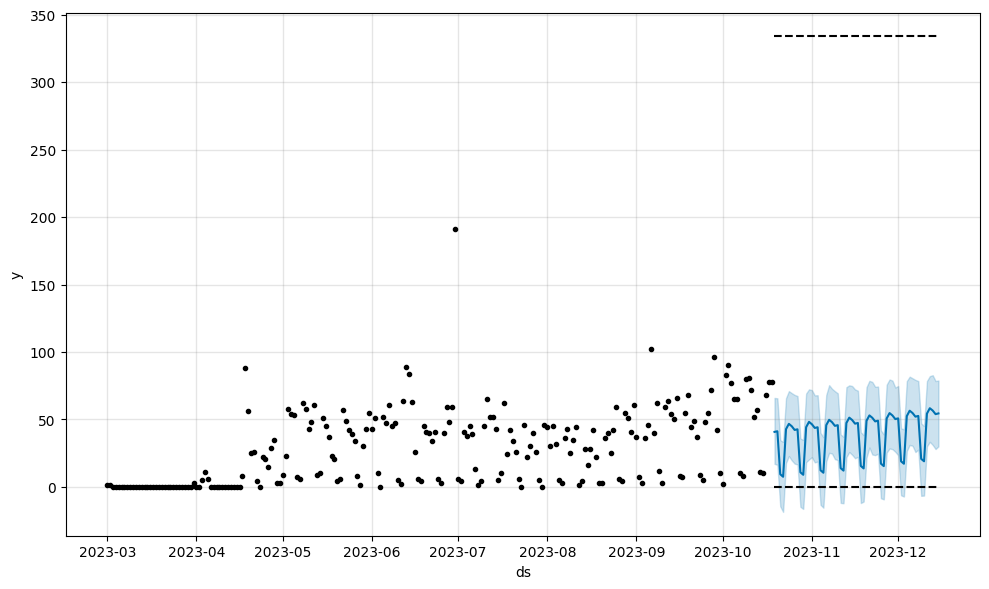

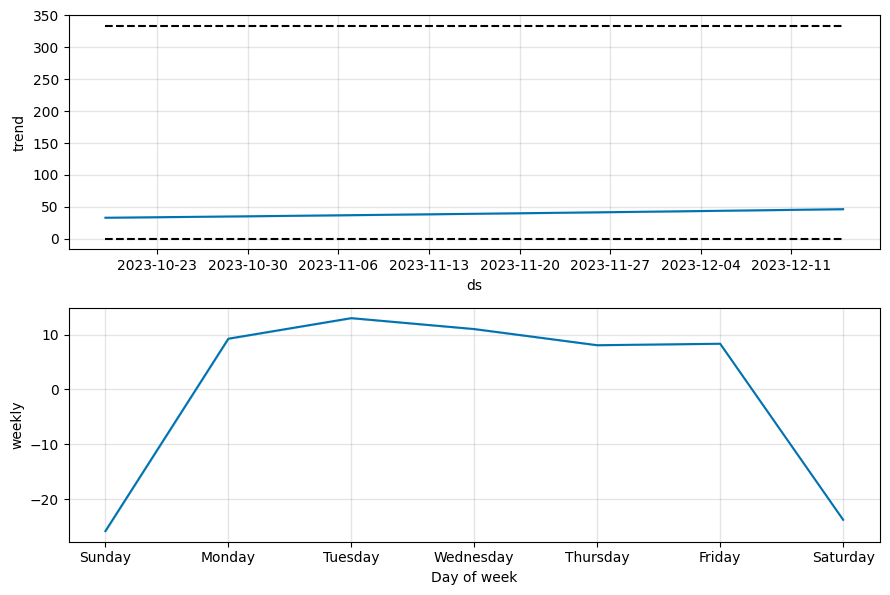

In [38]:
models_list=models_list_base
forecast_list=forecast_list_base
for i in range(len(models_list)):
    print(i)
    models_list[i].plot(forecast_list[i])
    models_list[i].plot_components(forecast_list[i])

### 9.2 Priority Wise Models

0
1
2
3
4


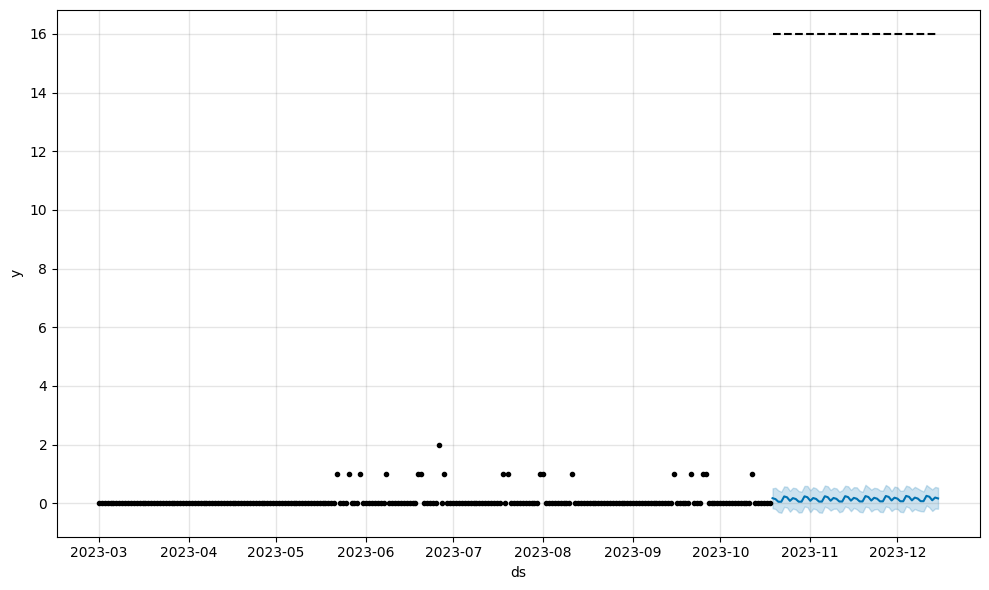

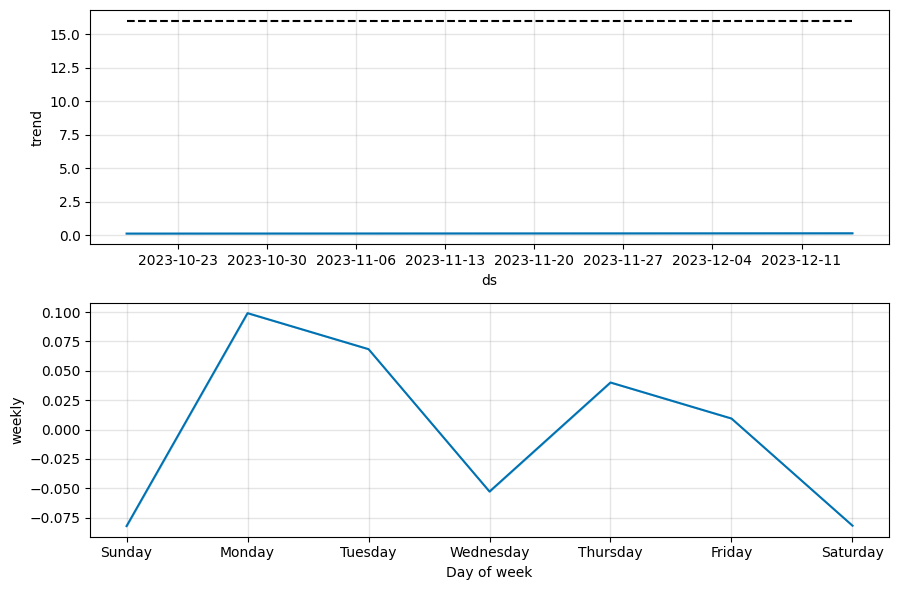

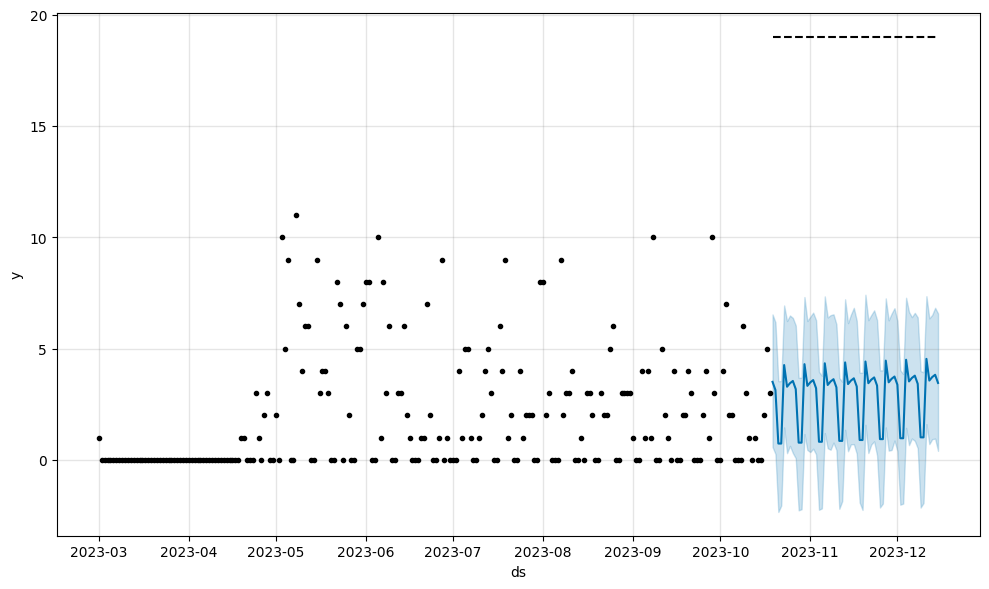

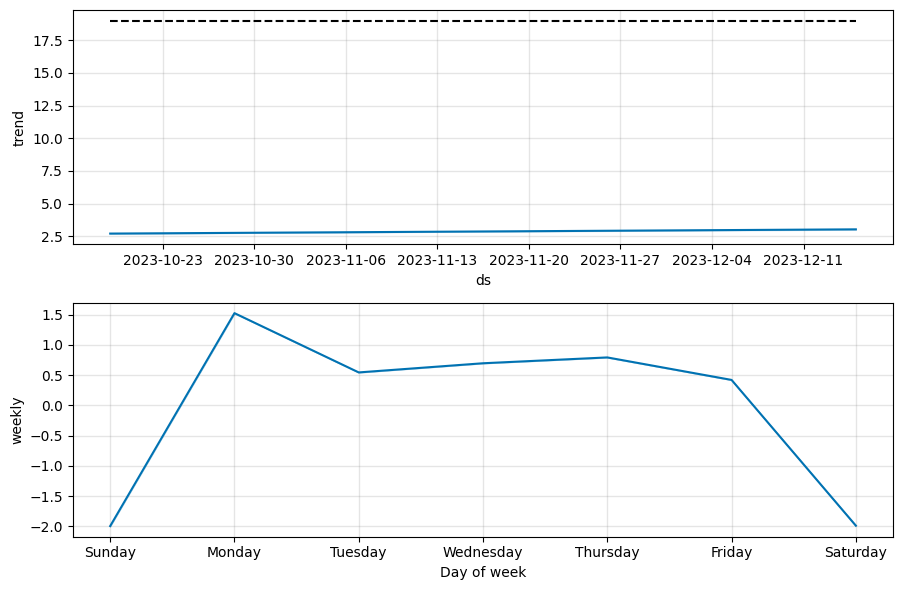

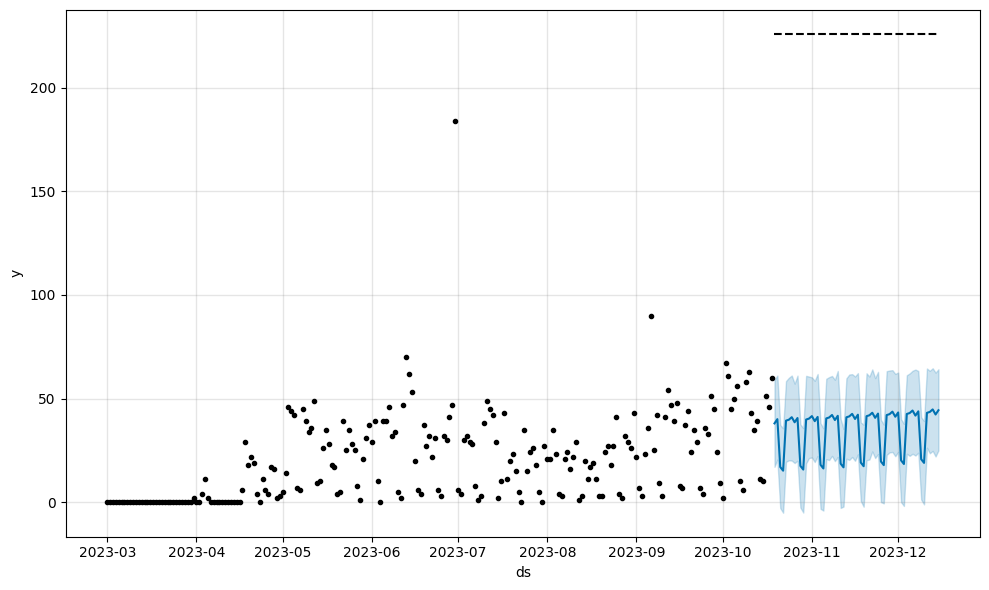

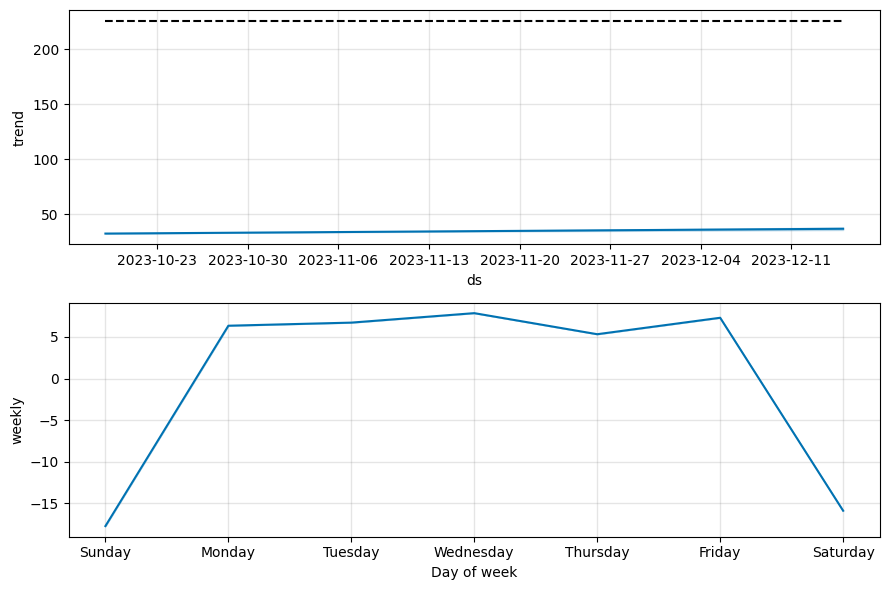

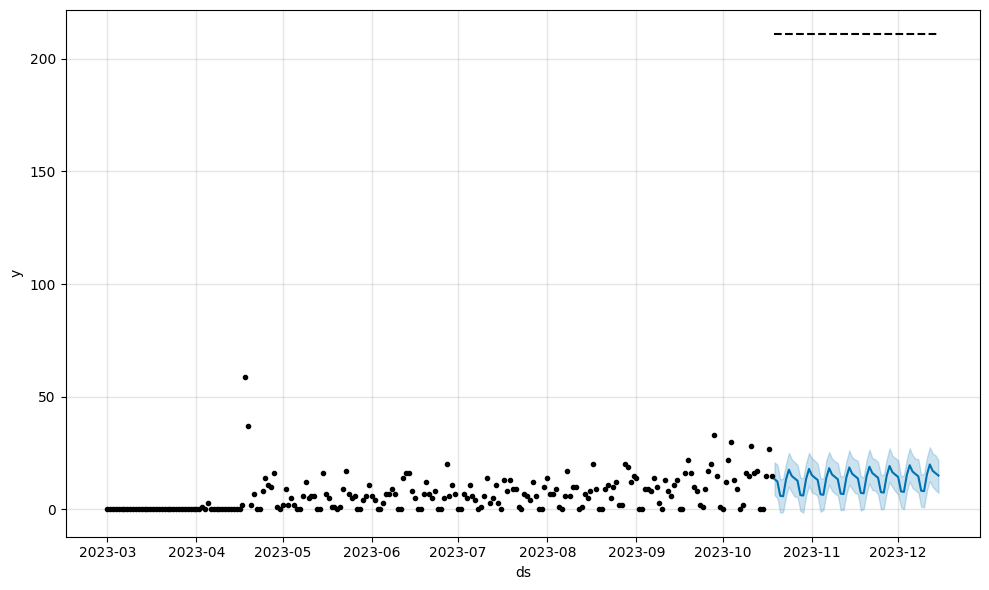

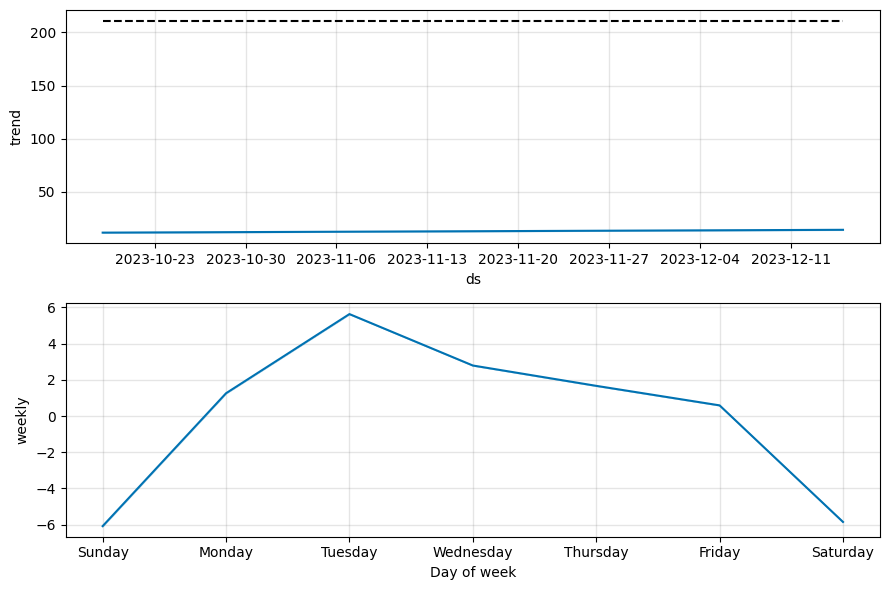

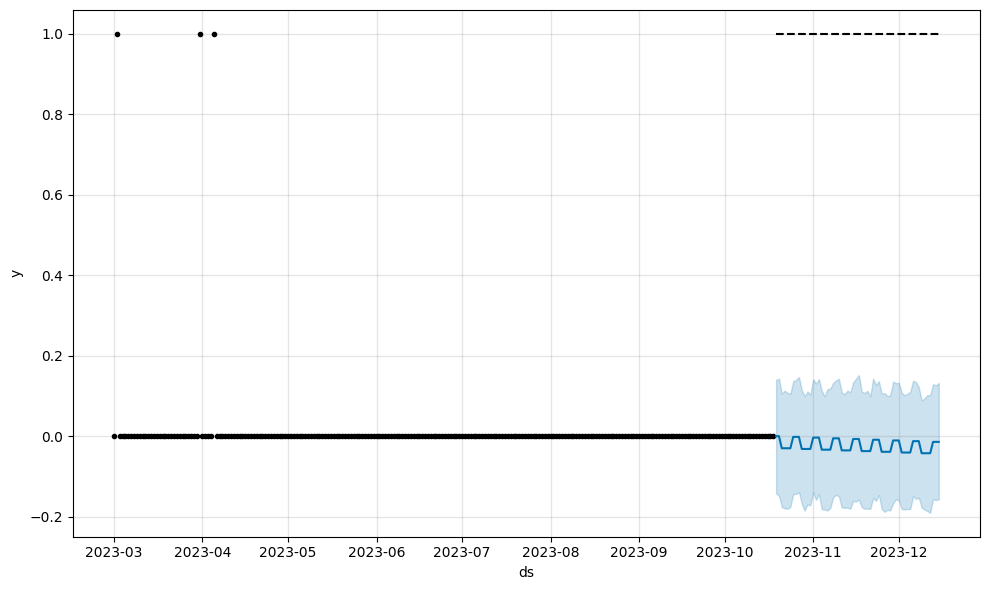

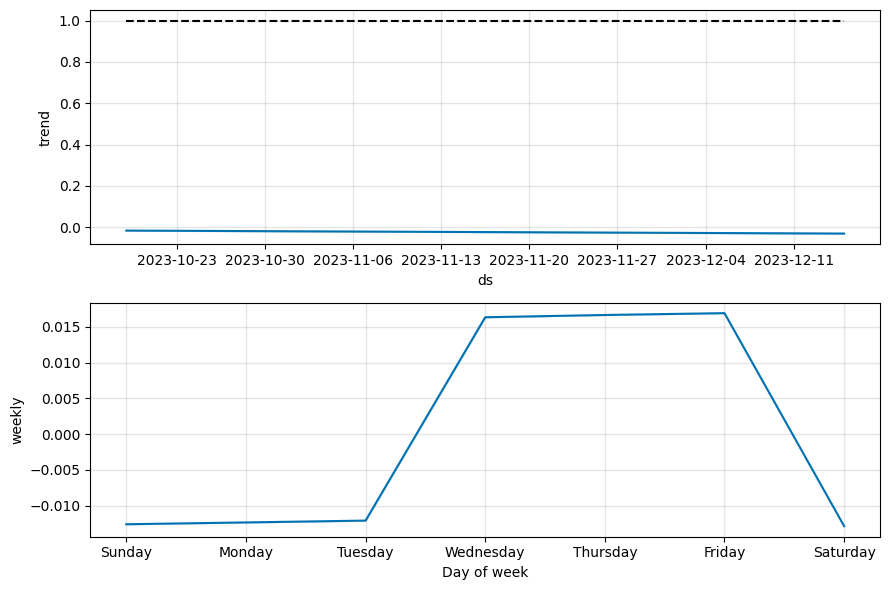

In [39]:
models_list=models_list_priority_wise
forecast_list=forecast_list_priority_wise
for i in range(len(models_list)):
    print(i)
    models_list[i].plot(forecast_list[i])
    models_list[i].plot_components(forecast_list[i])

### 9.3 Category Wise Models

0
1
2
3
4
5
6
7


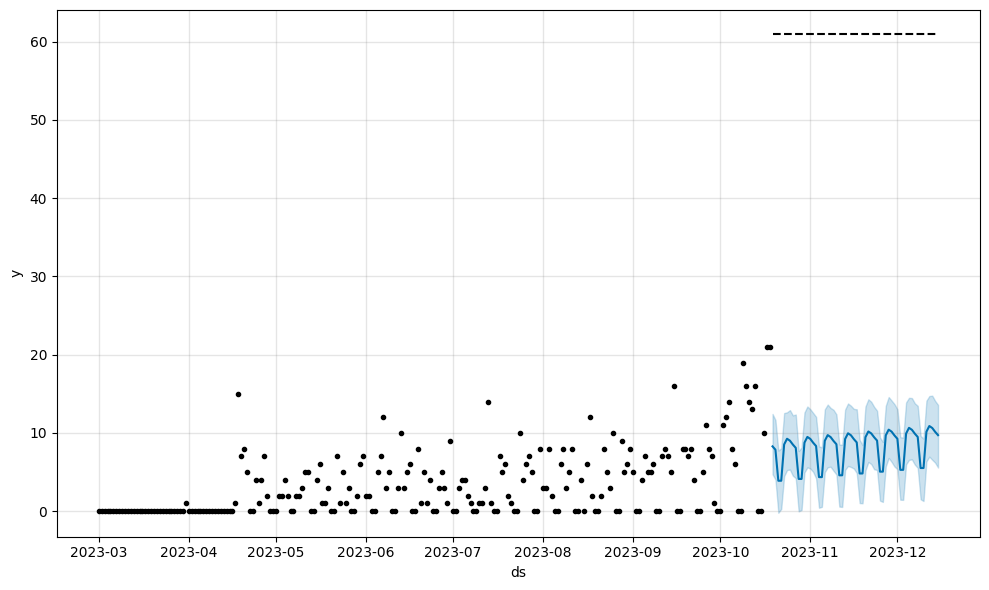

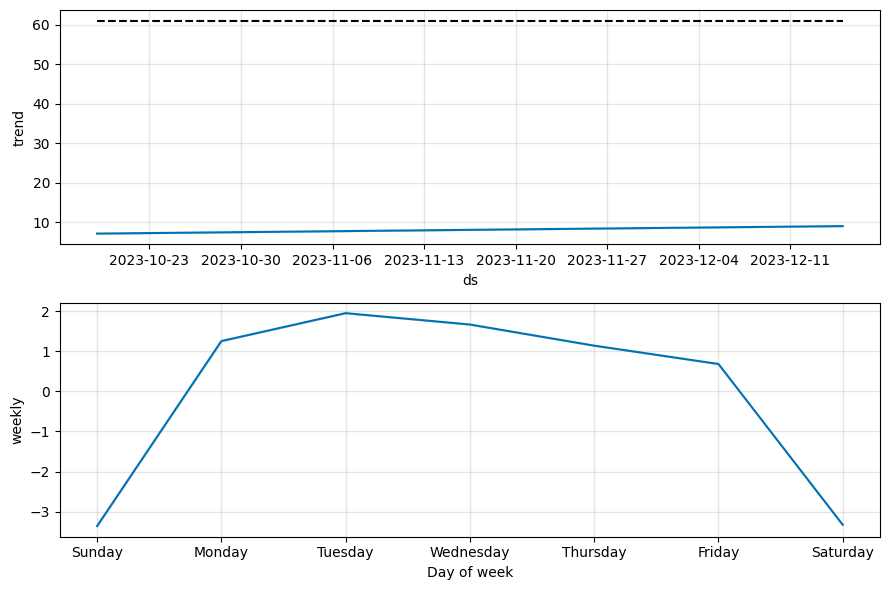

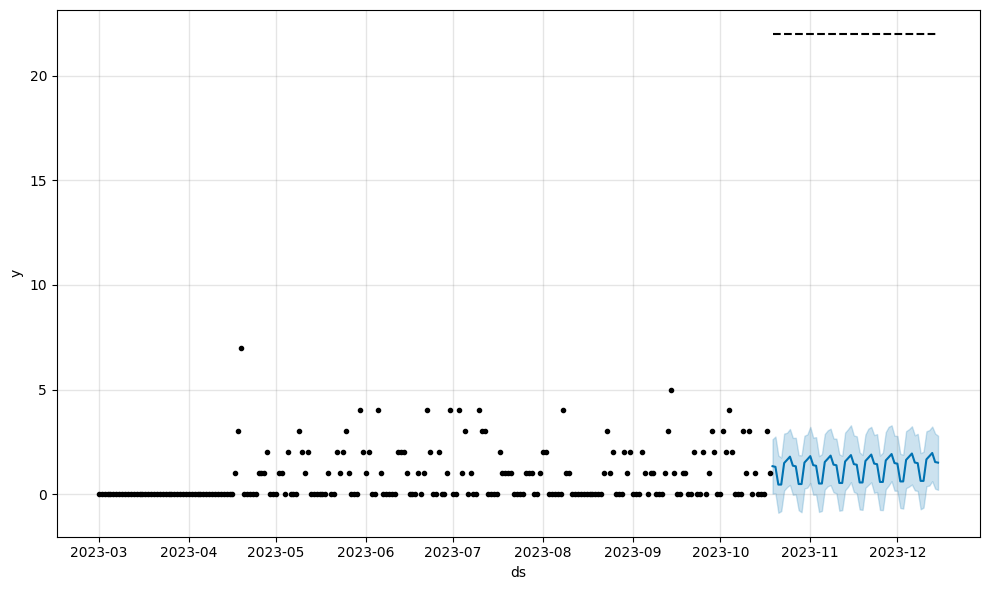

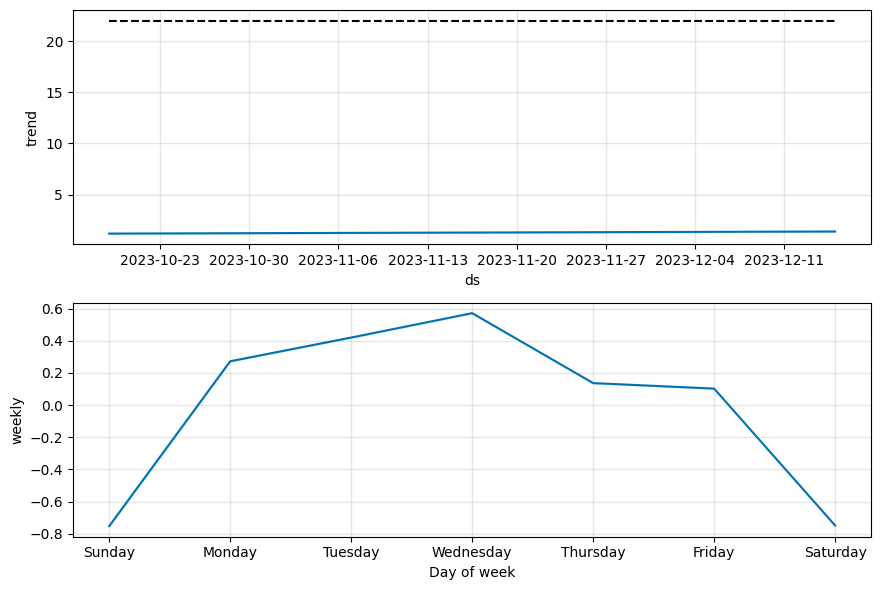

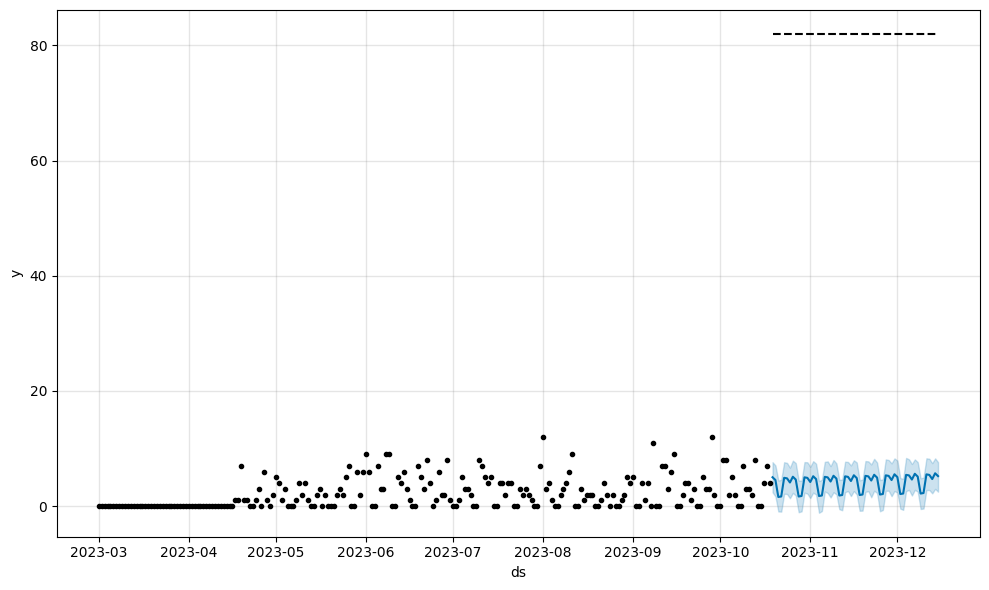

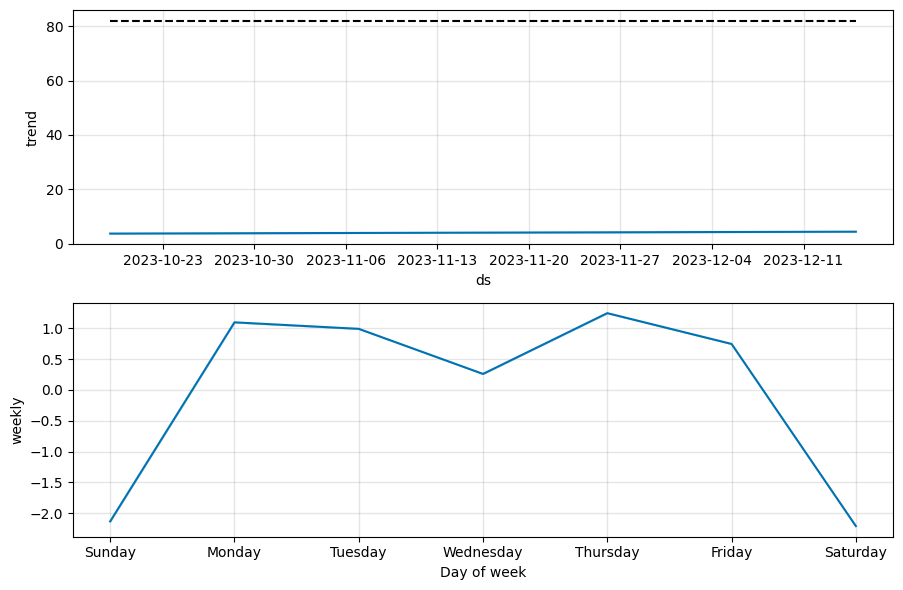

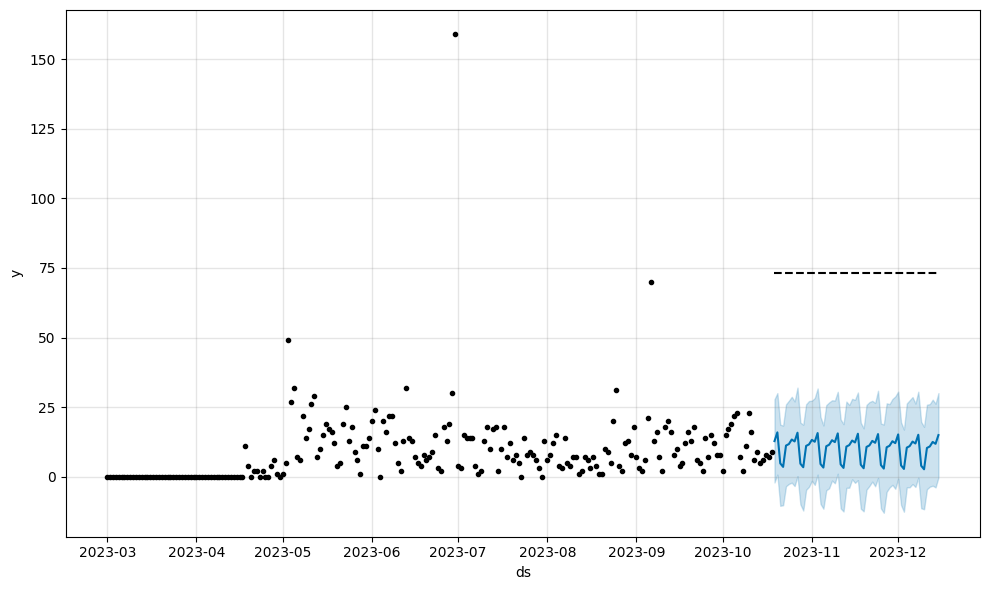

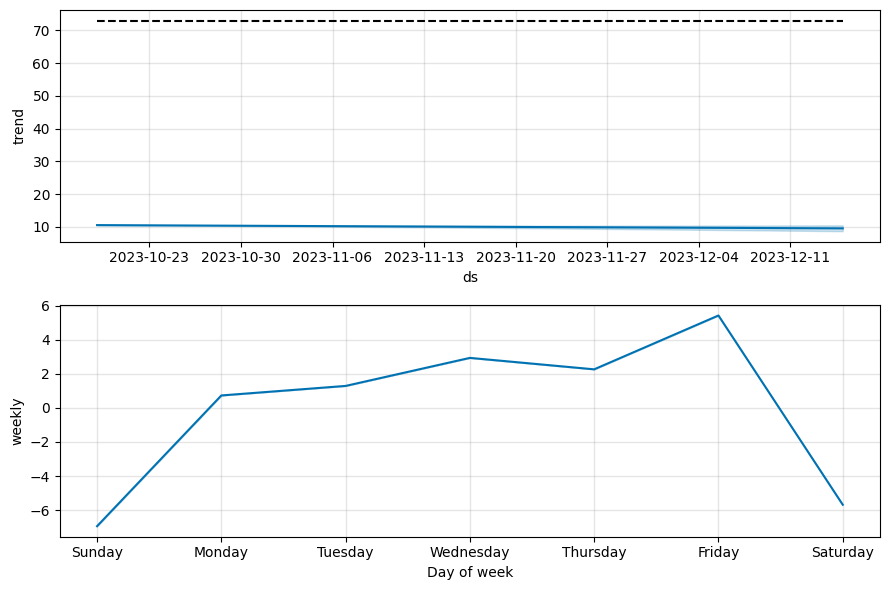

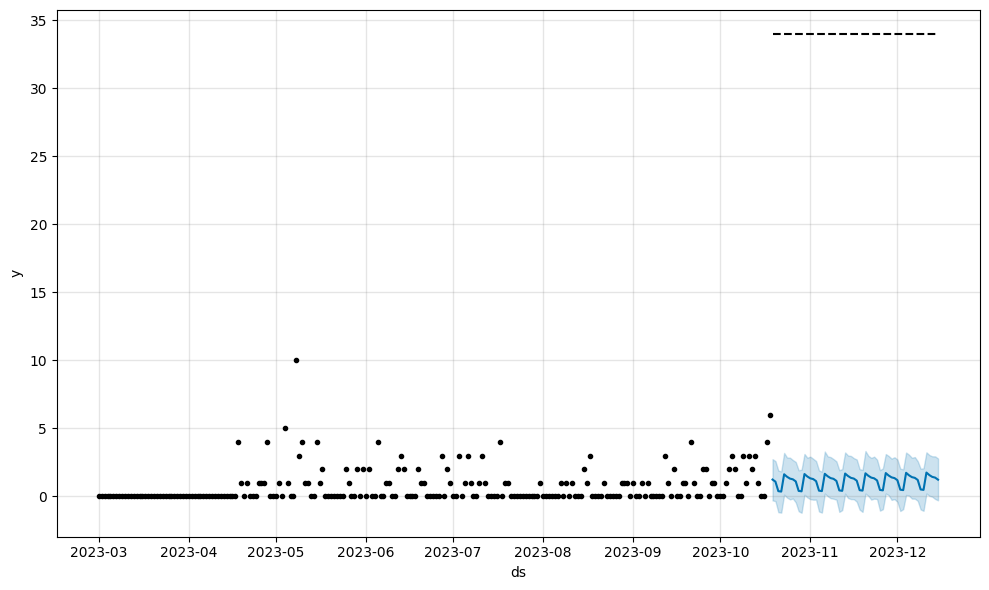

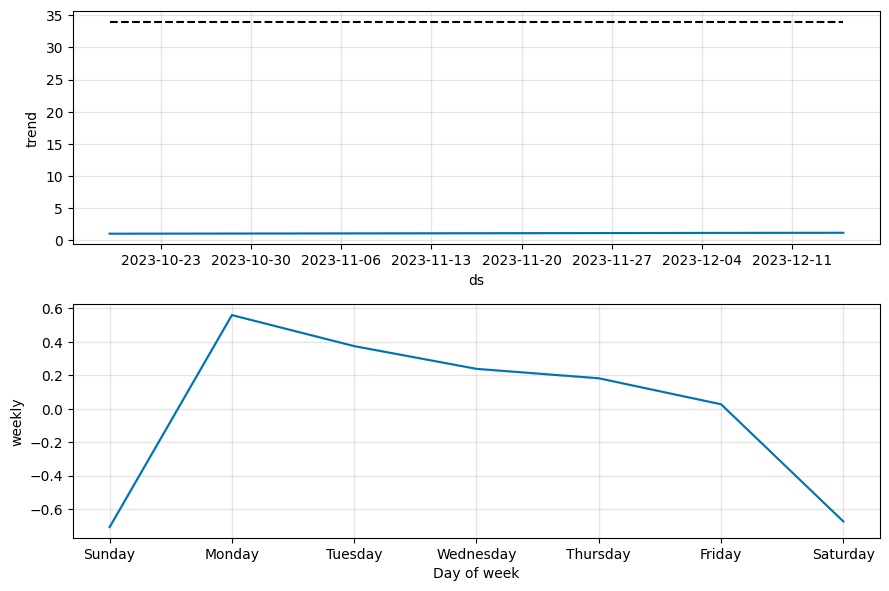

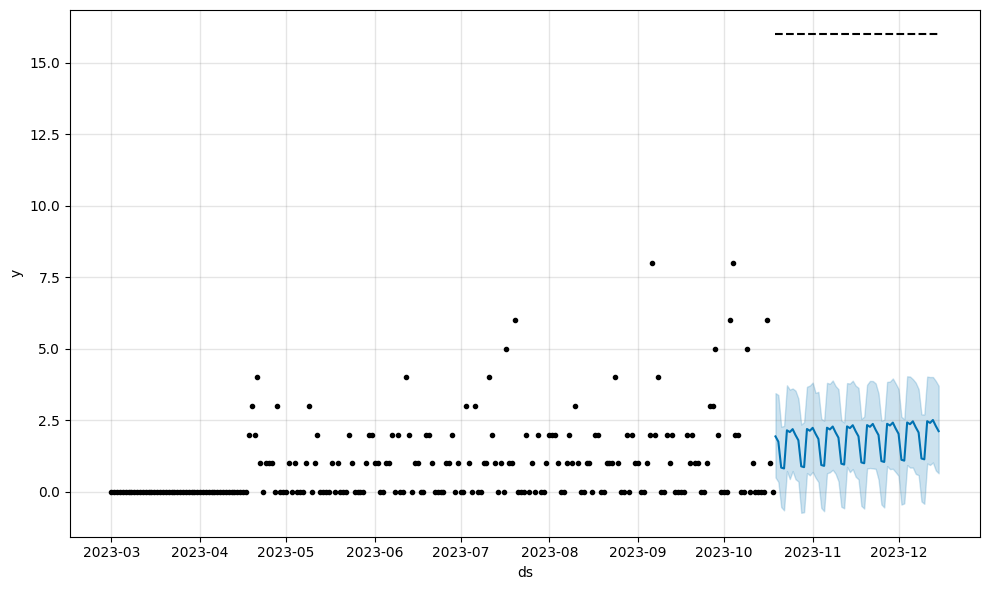

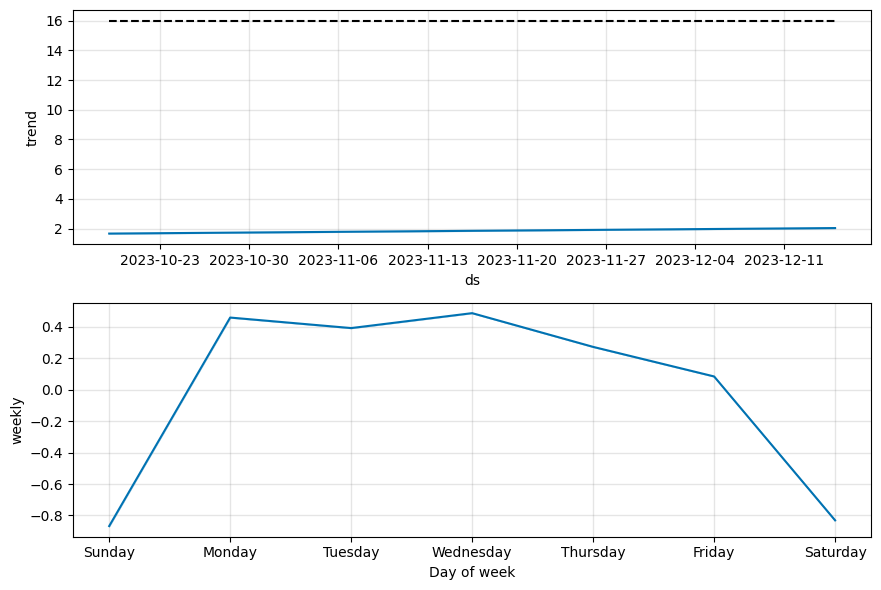

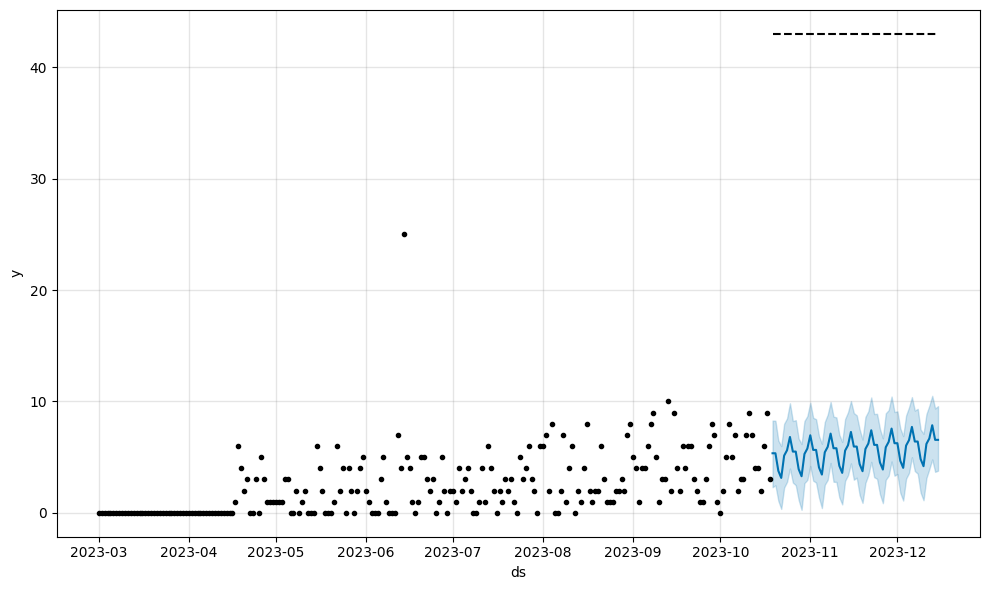

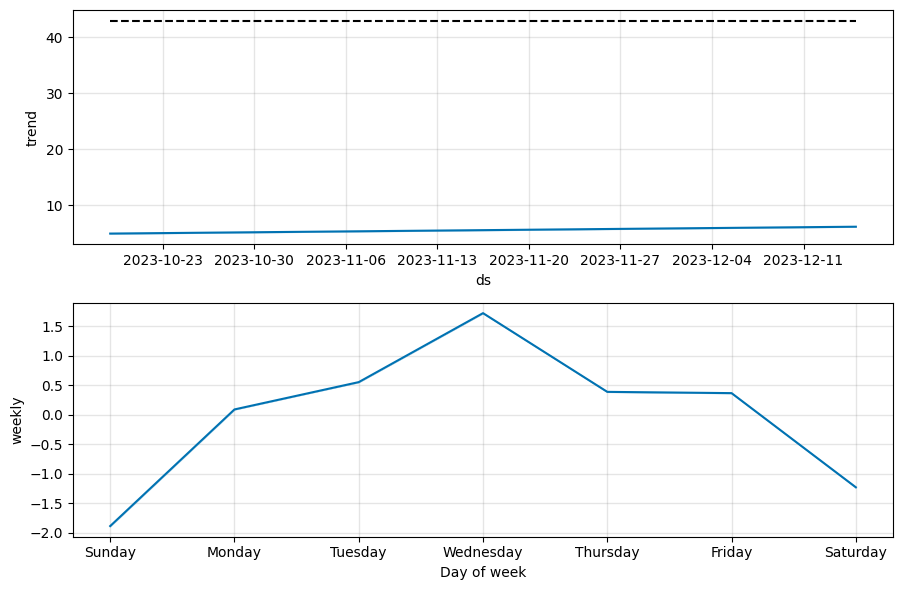

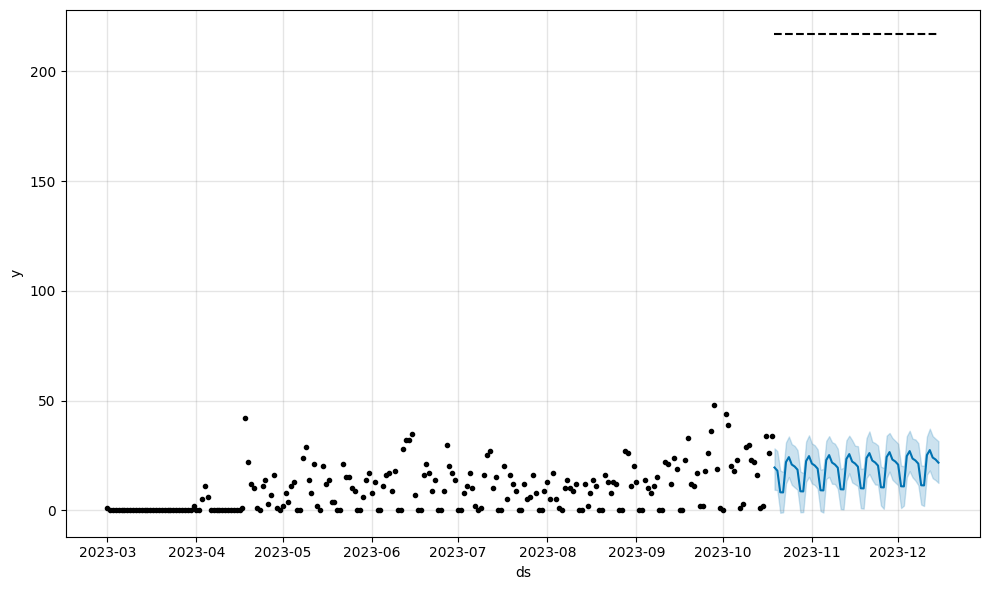

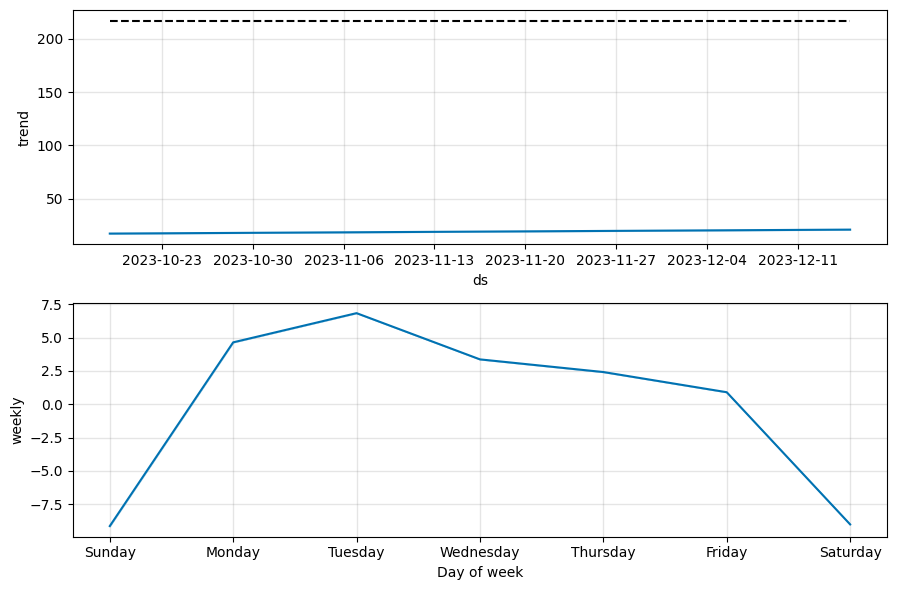

In [40]:
models_list=models_list_category_wise
forecast_list=forecast_list_category_wise
for i in range(len(models_list)):
    print(i)
    models_list[i].plot(forecast_list[i])
    models_list[i].plot_components(forecast_list[i])

### 9.4 Category-Priority Wise Models

0
1
2
3
4
5
6
7
8
9
10


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(facecolor='w', figsize=figsize)


11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


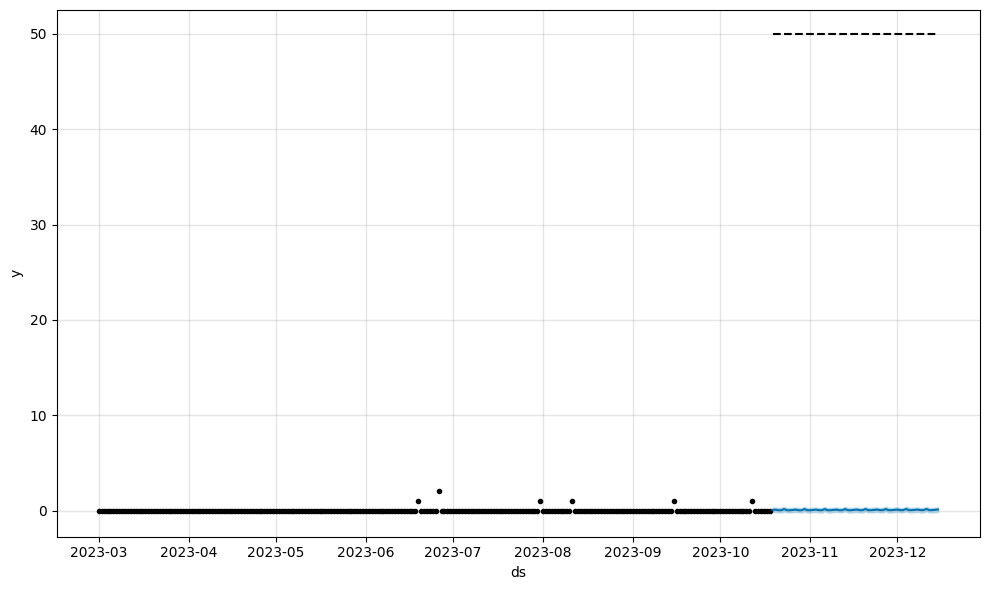

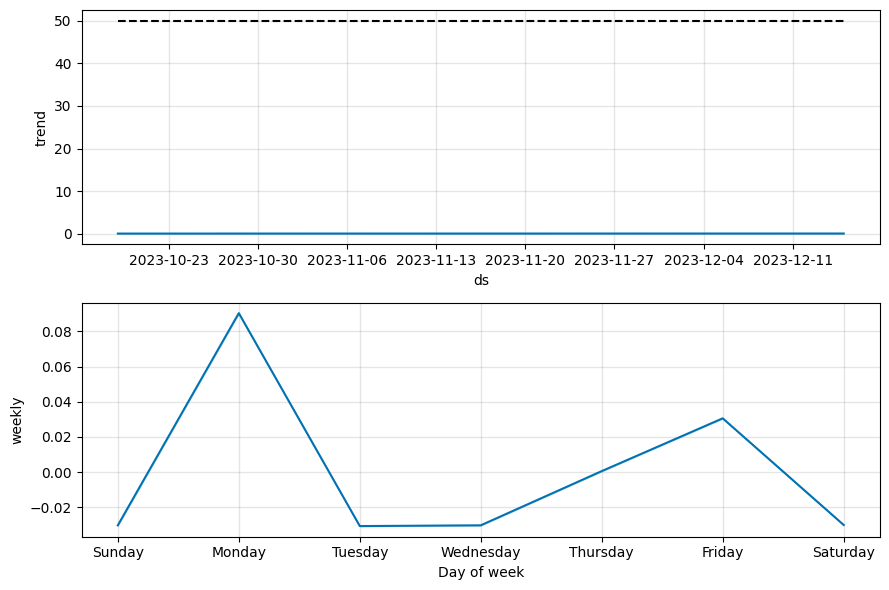

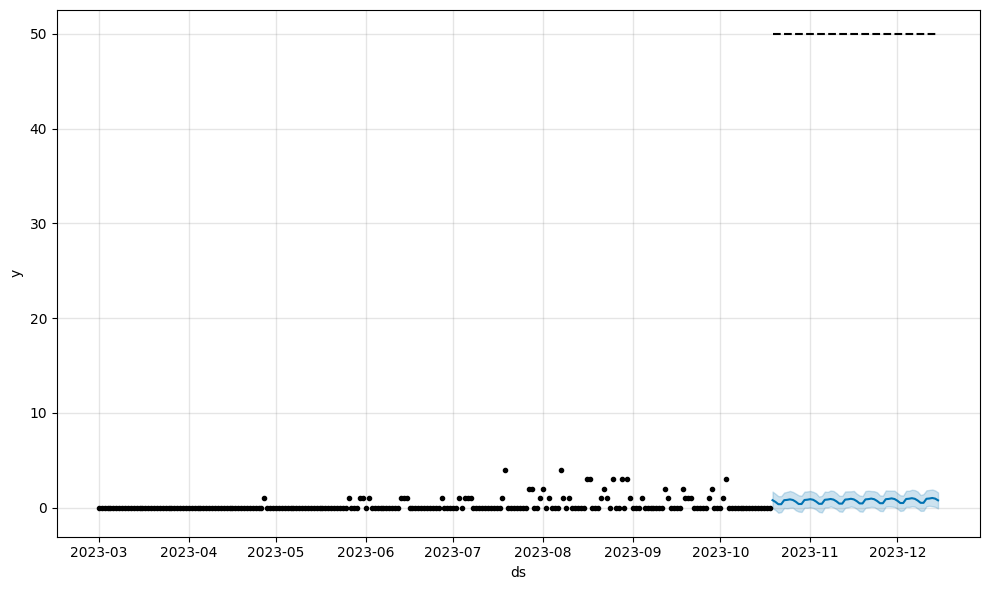

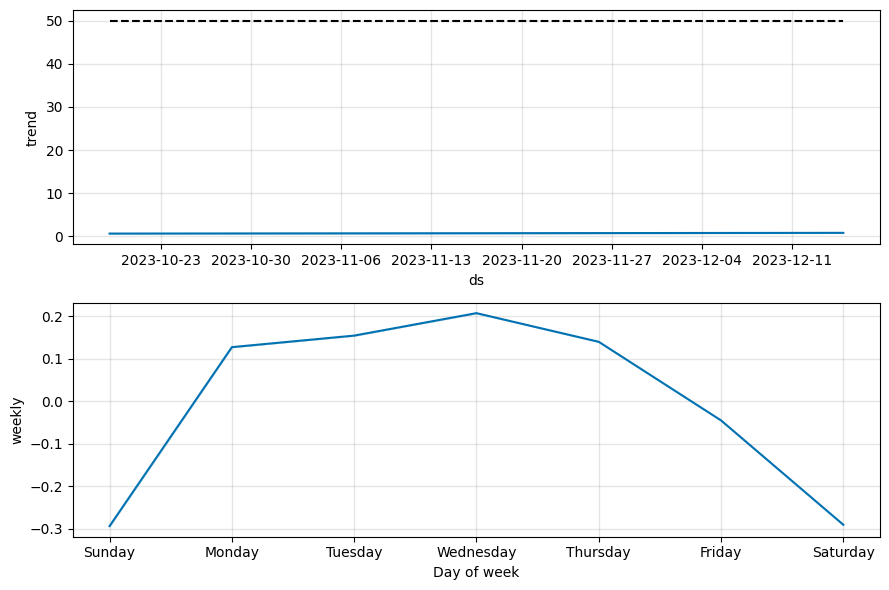

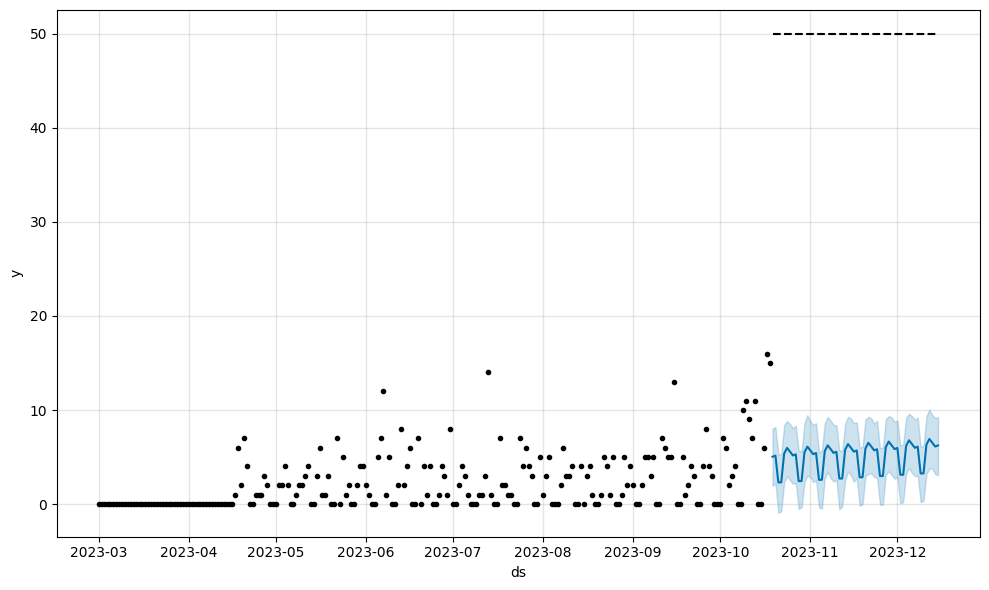

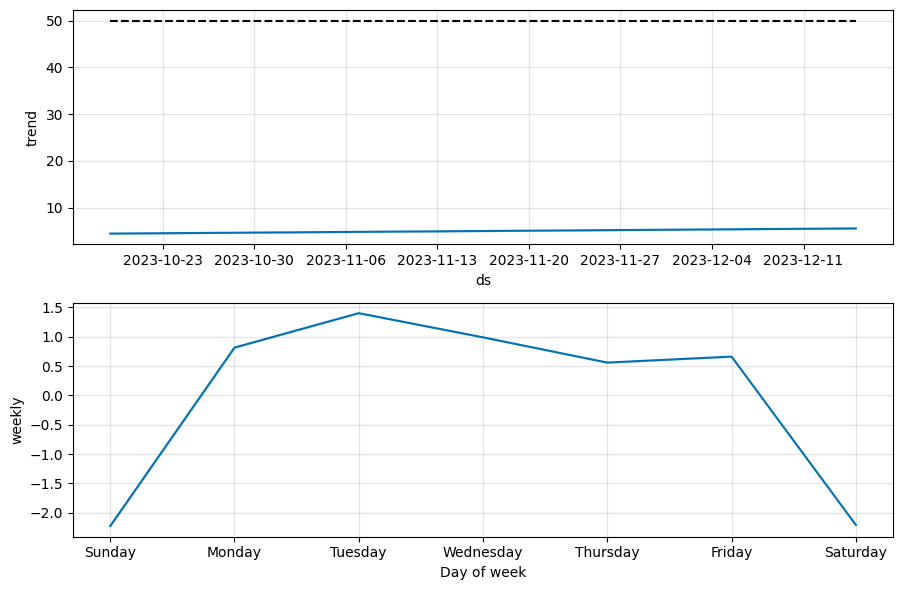

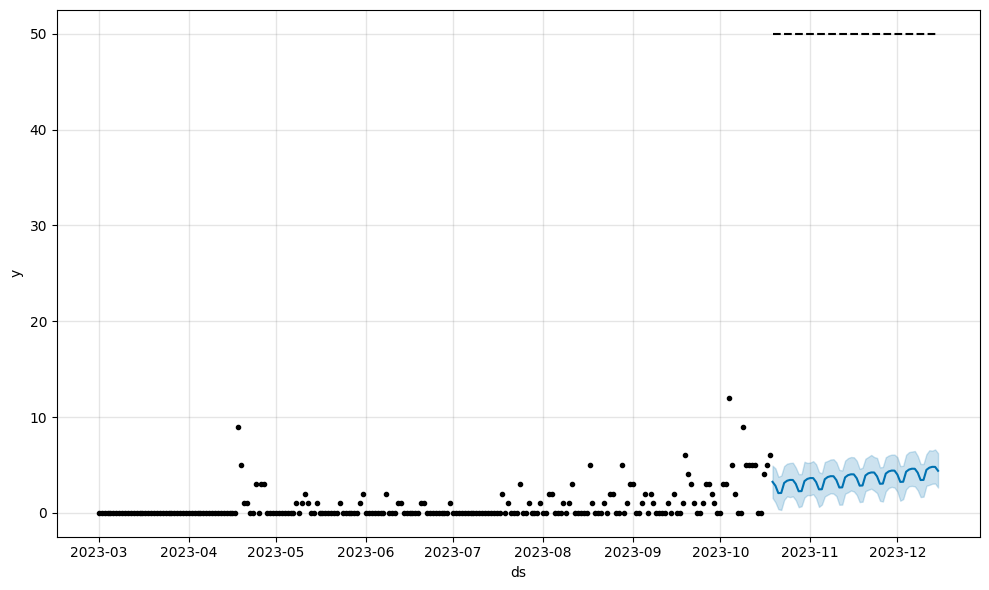

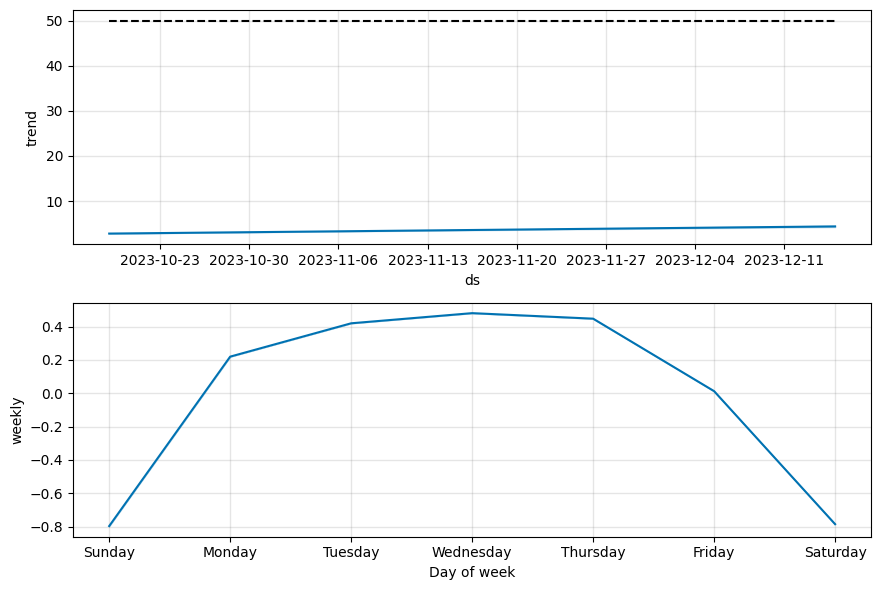

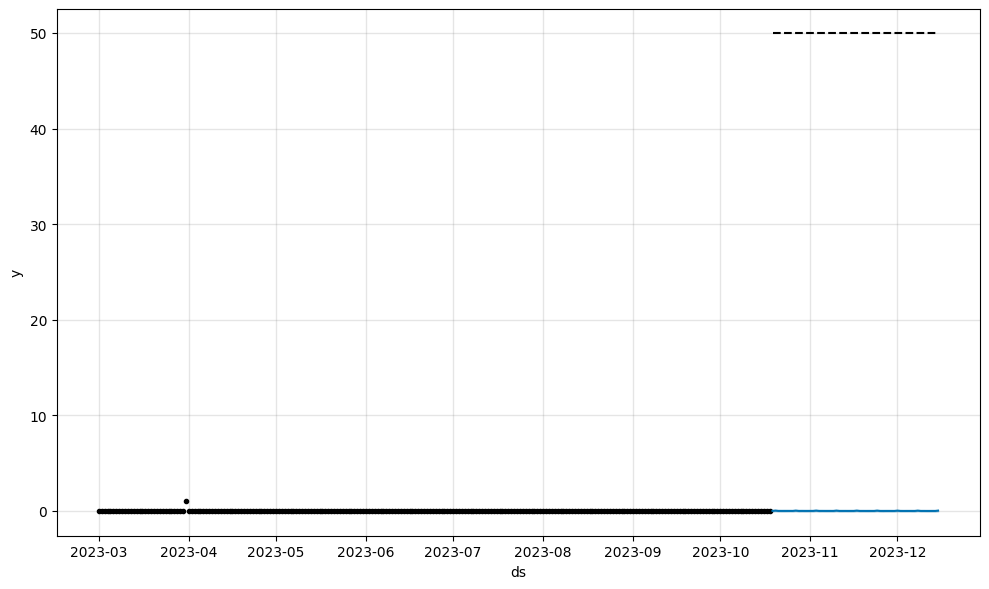

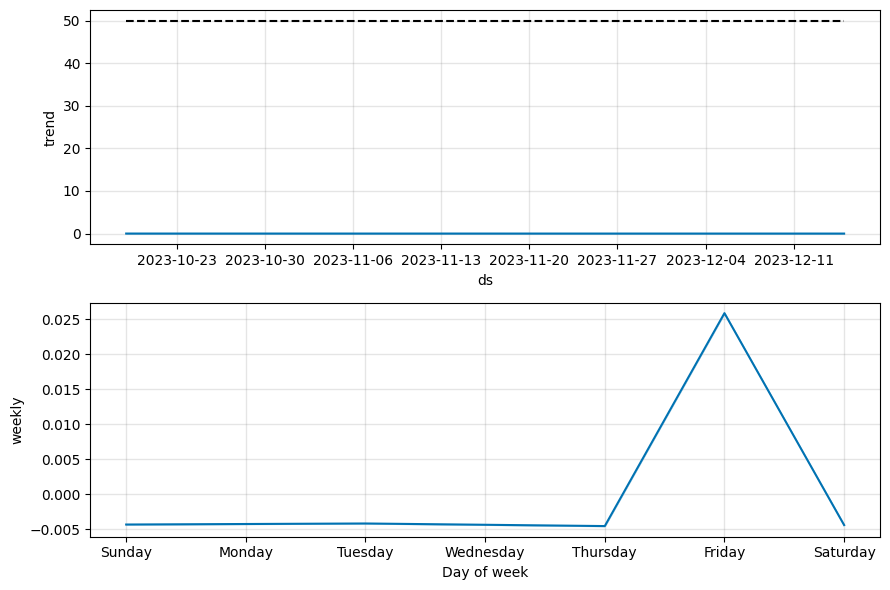

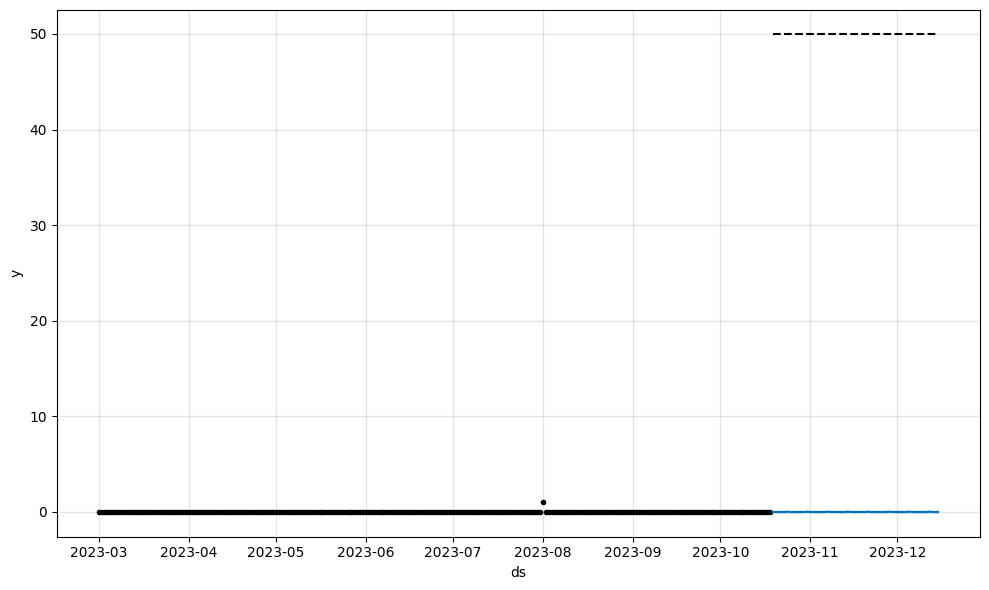

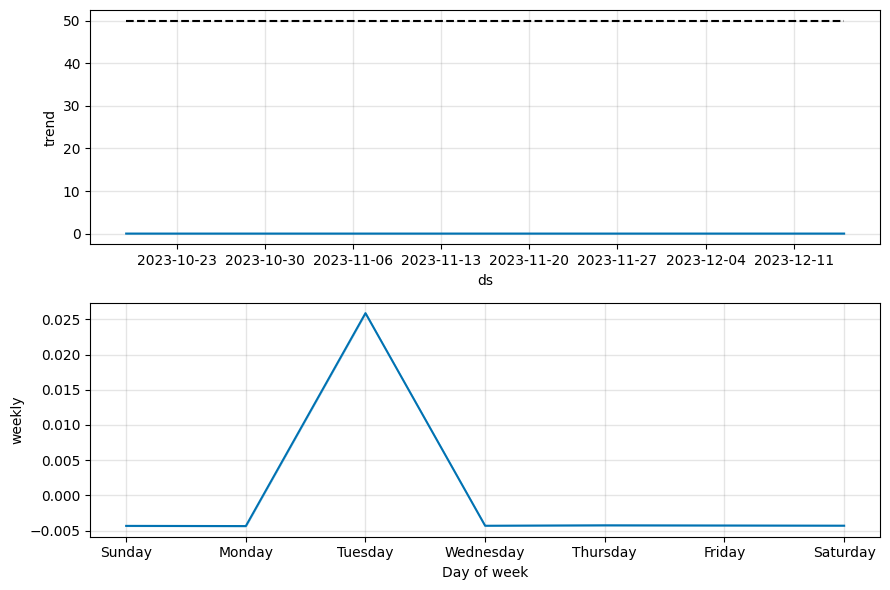

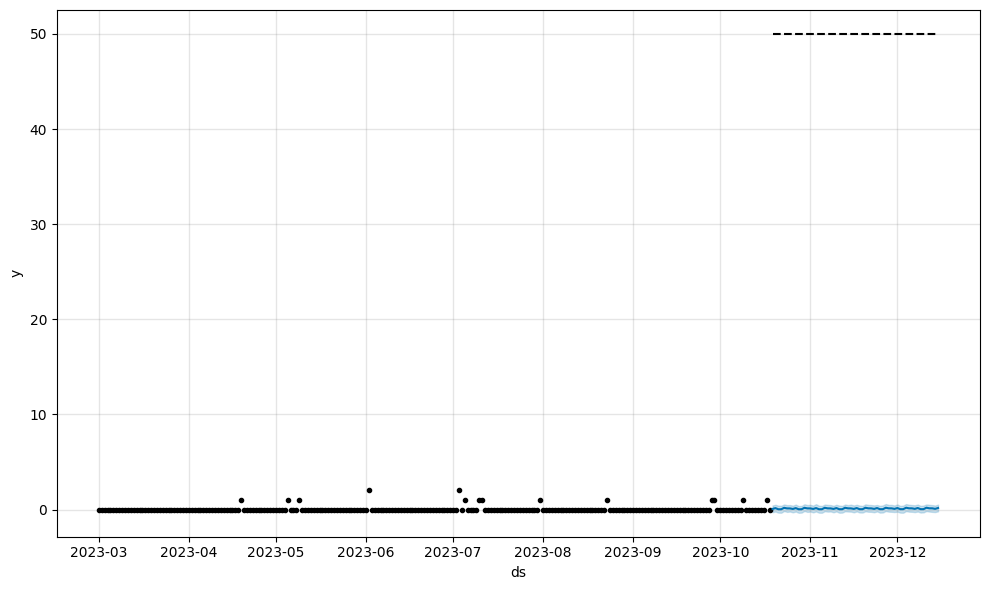

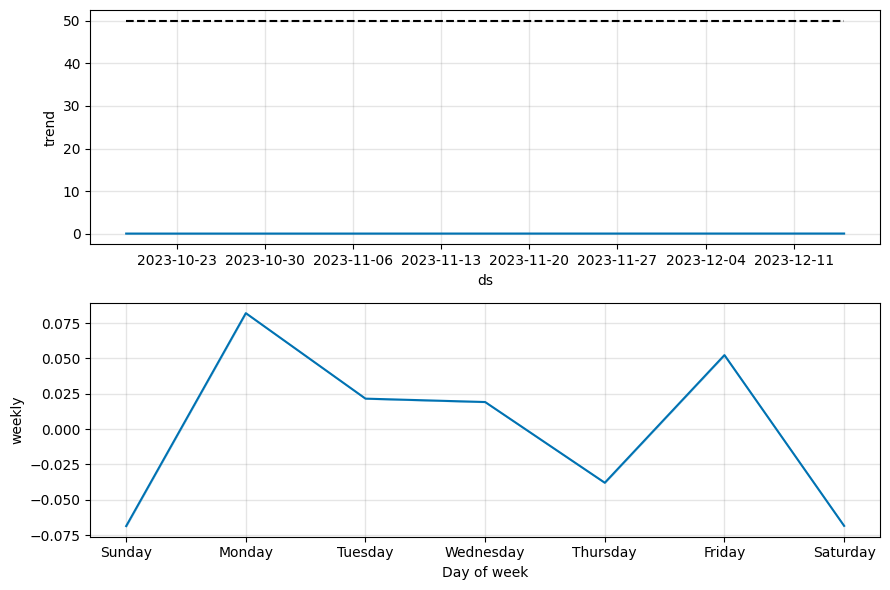

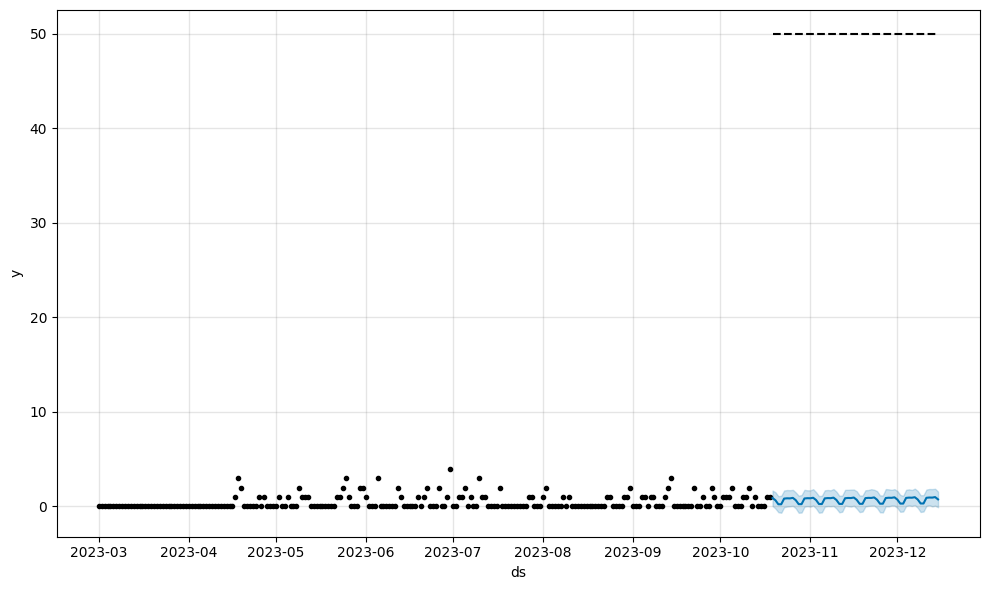

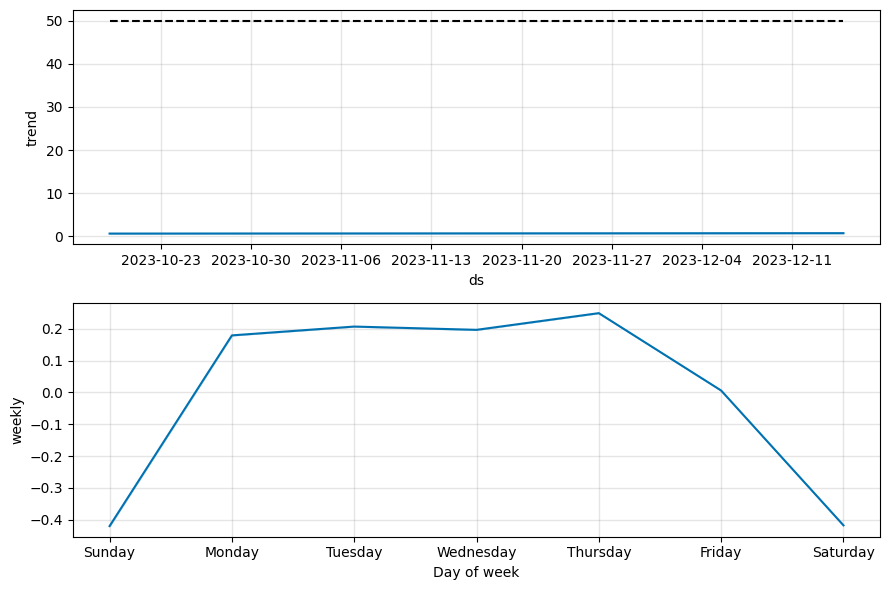

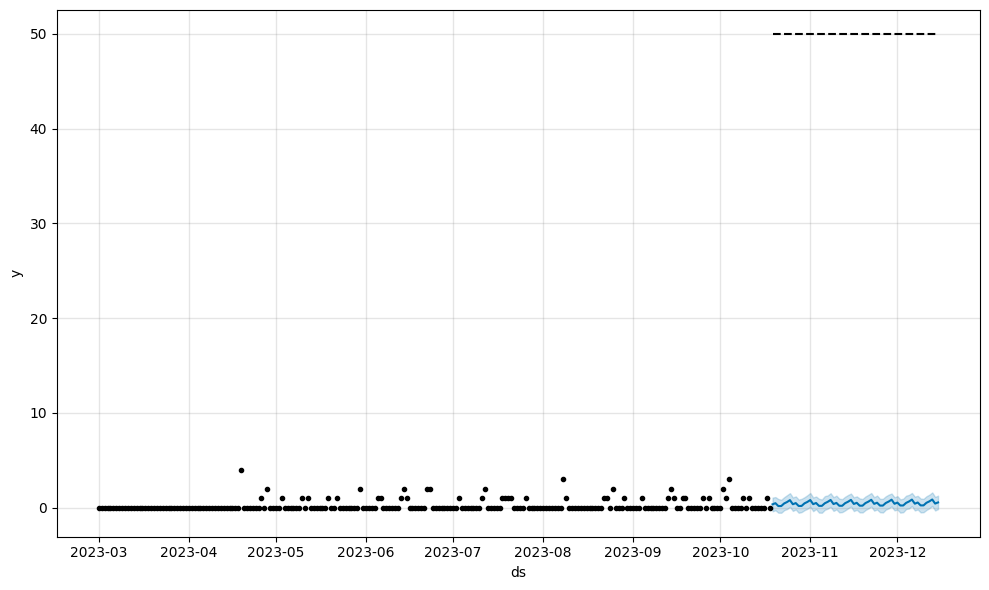

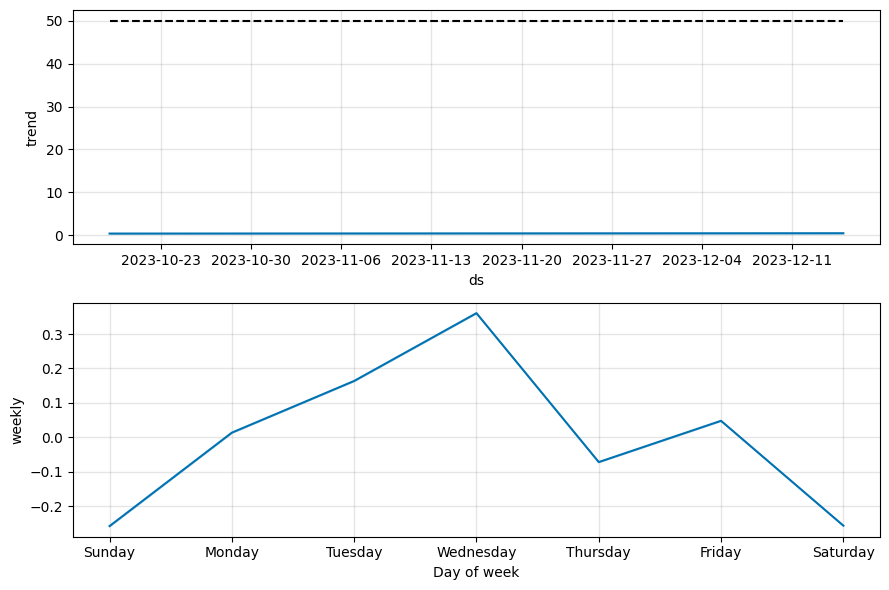

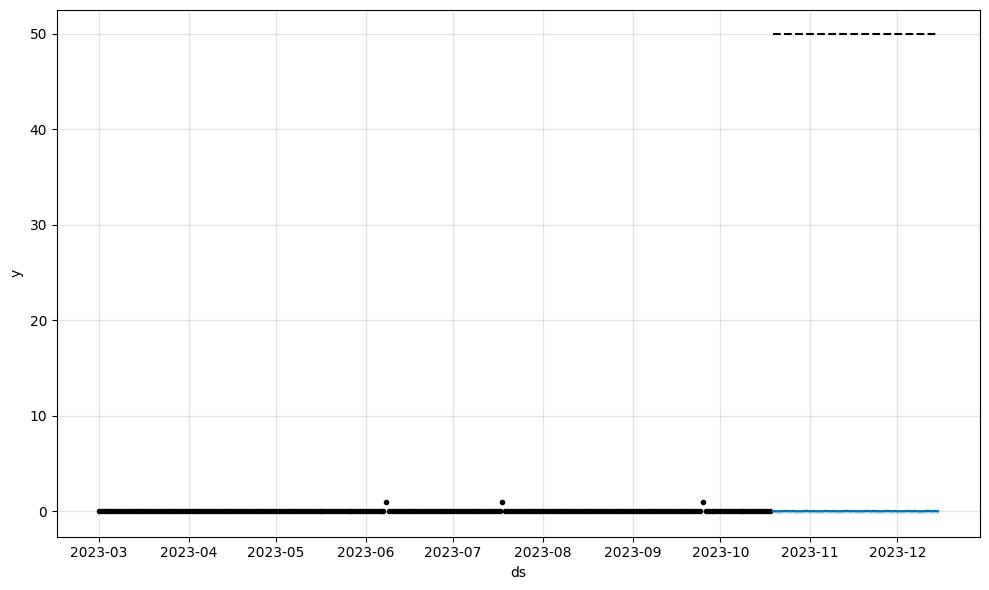

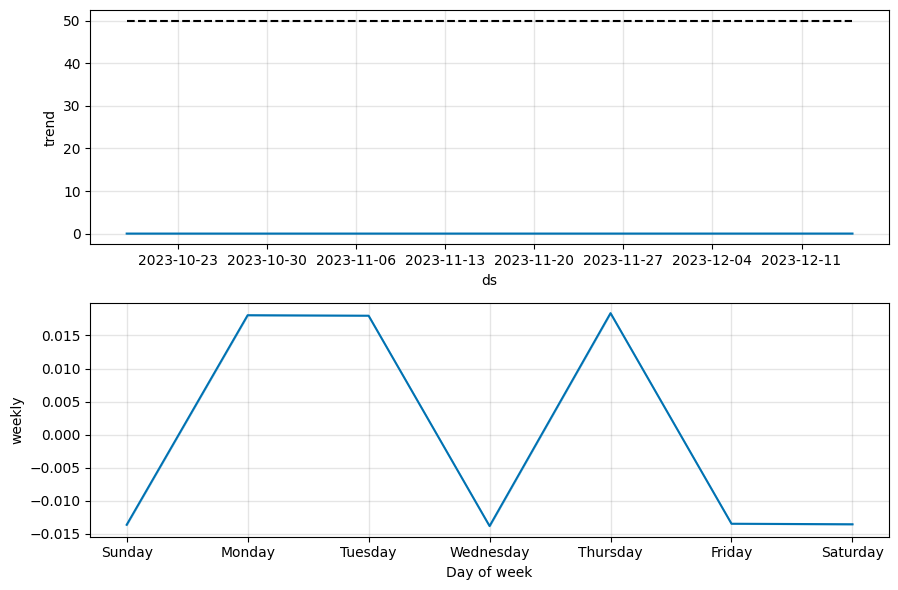

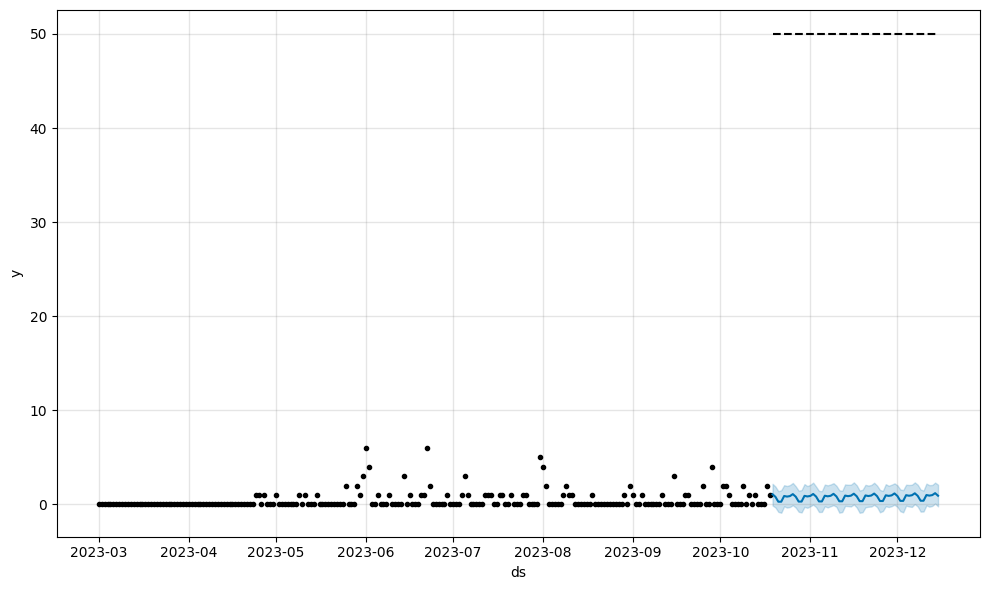

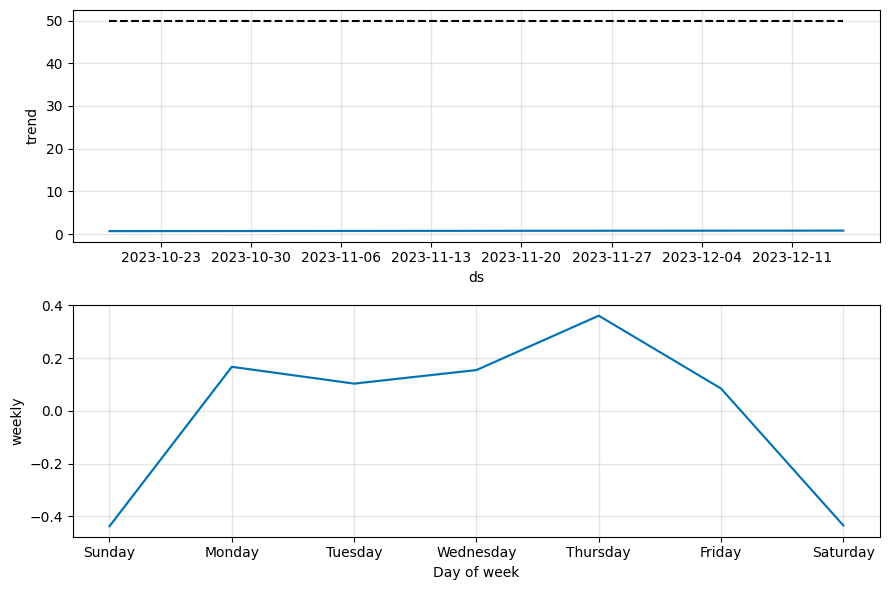

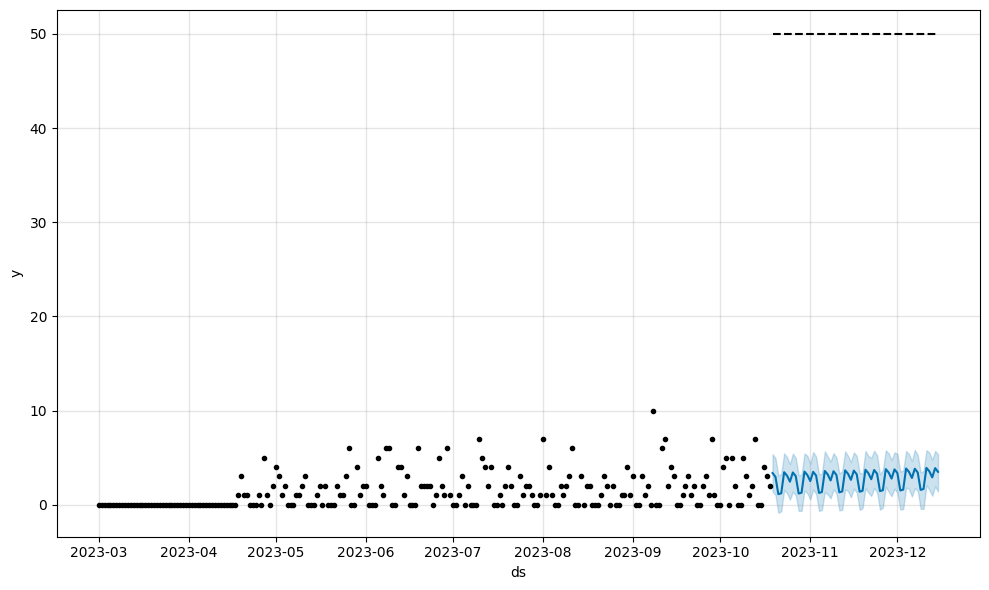

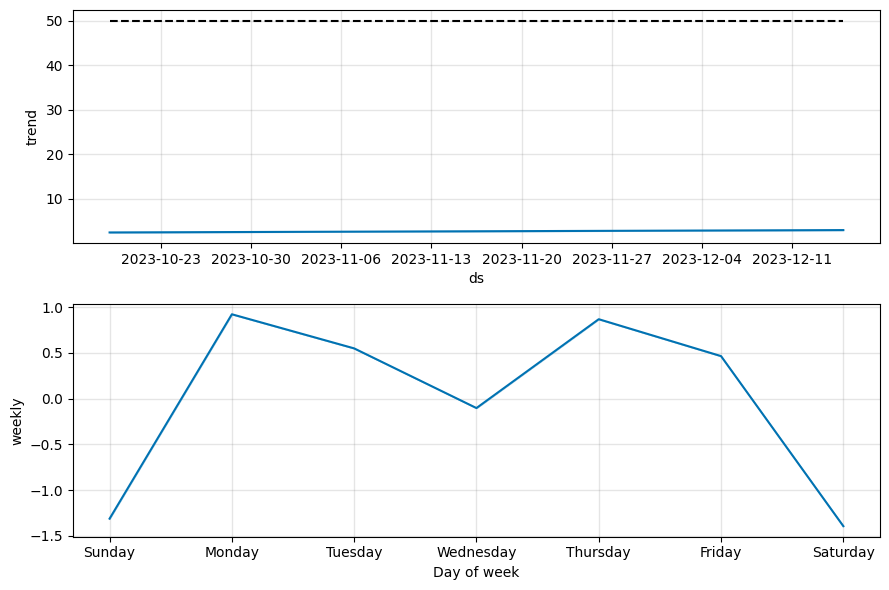

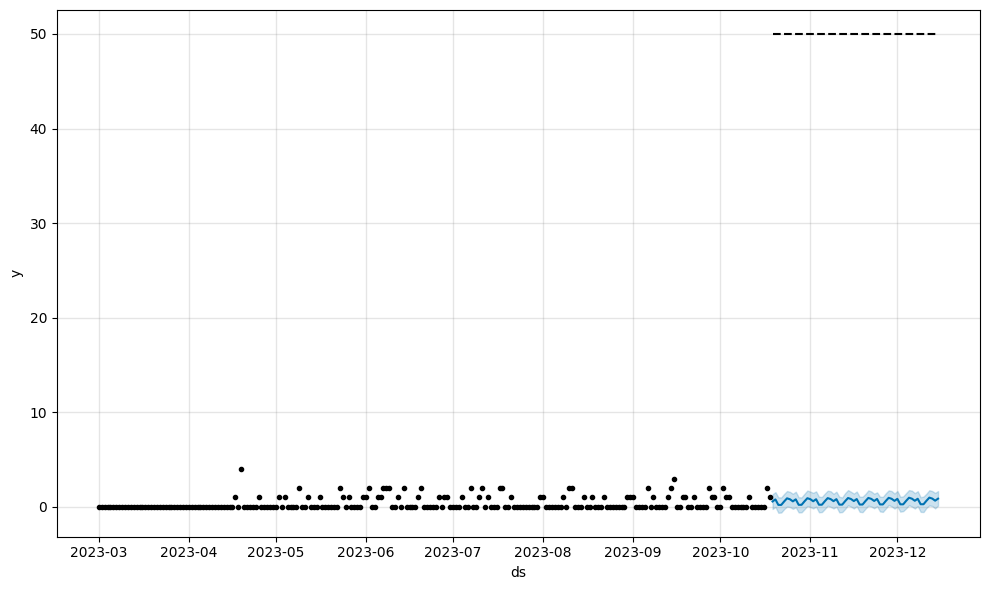

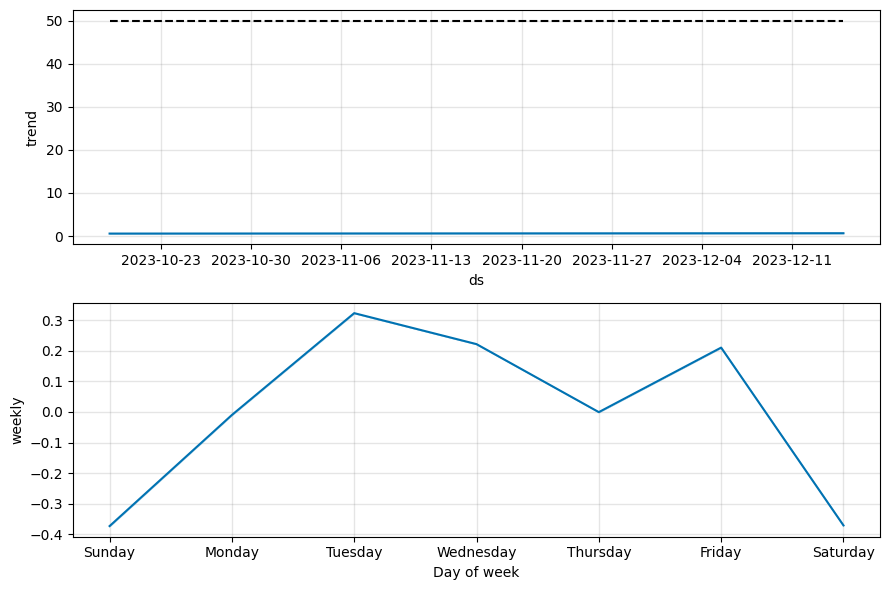

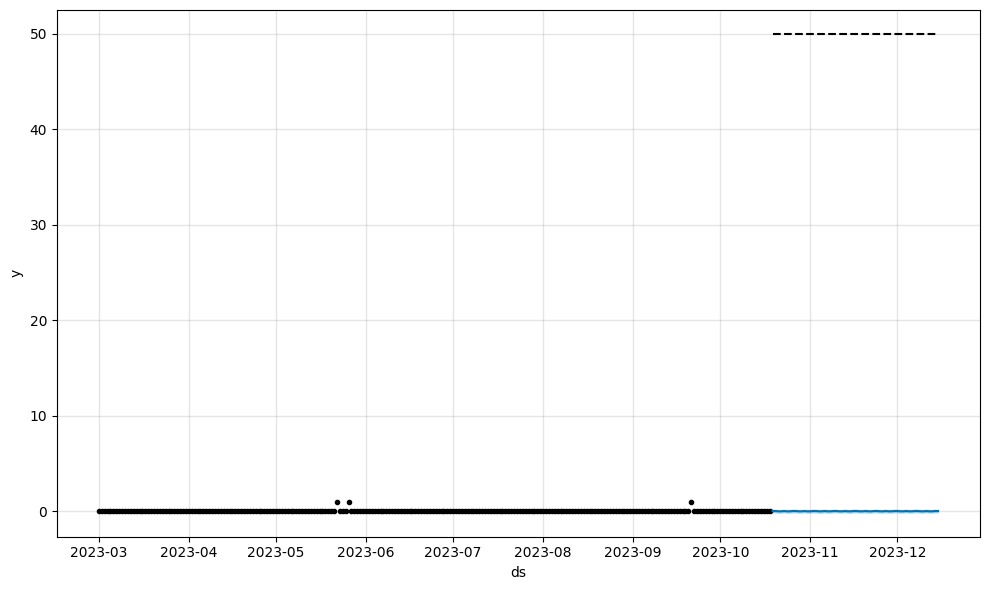

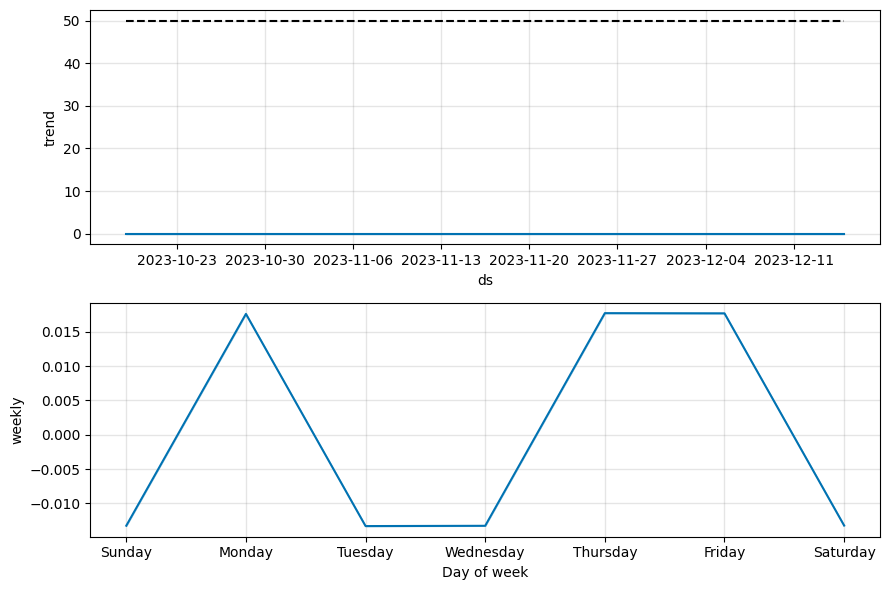

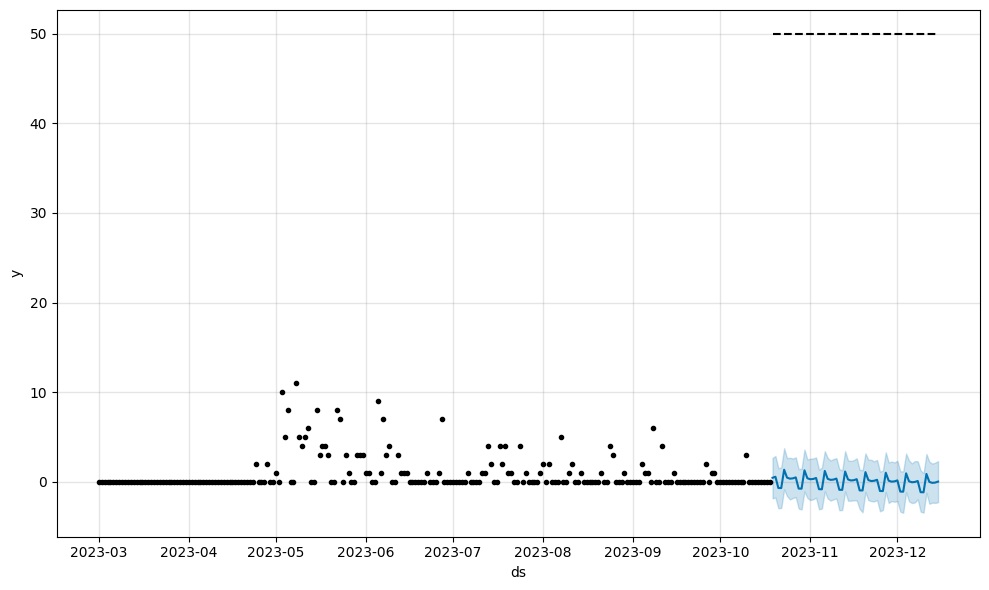

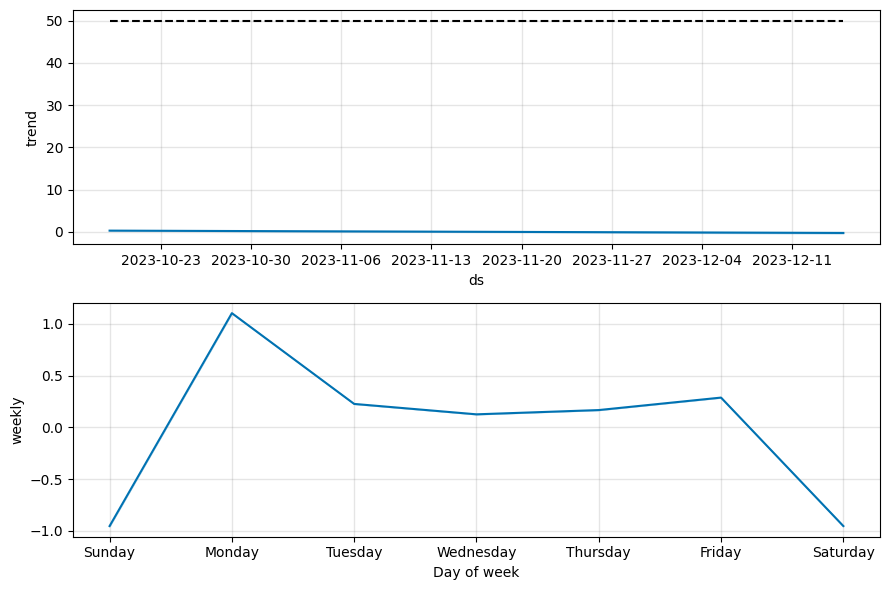

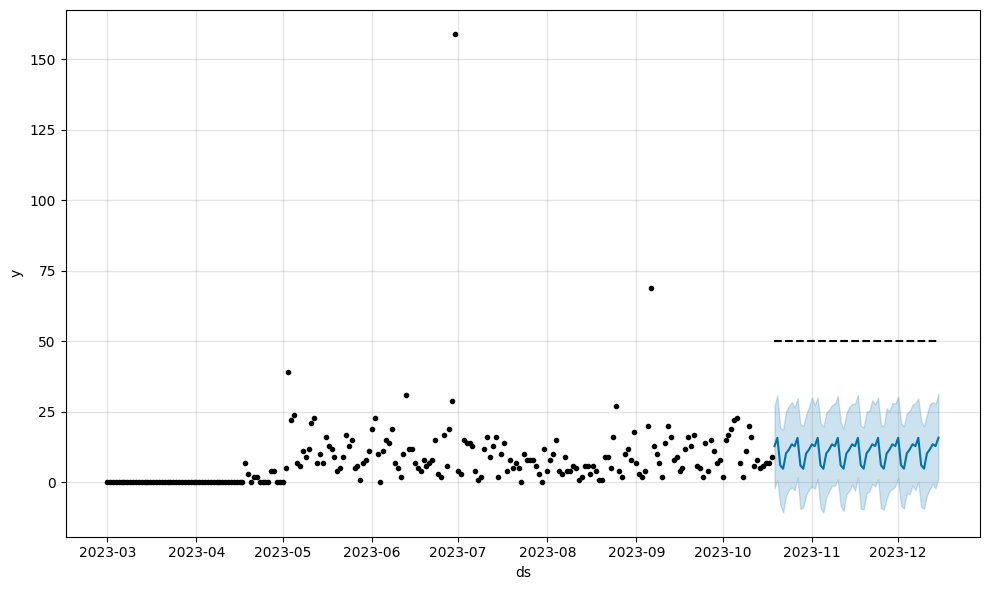

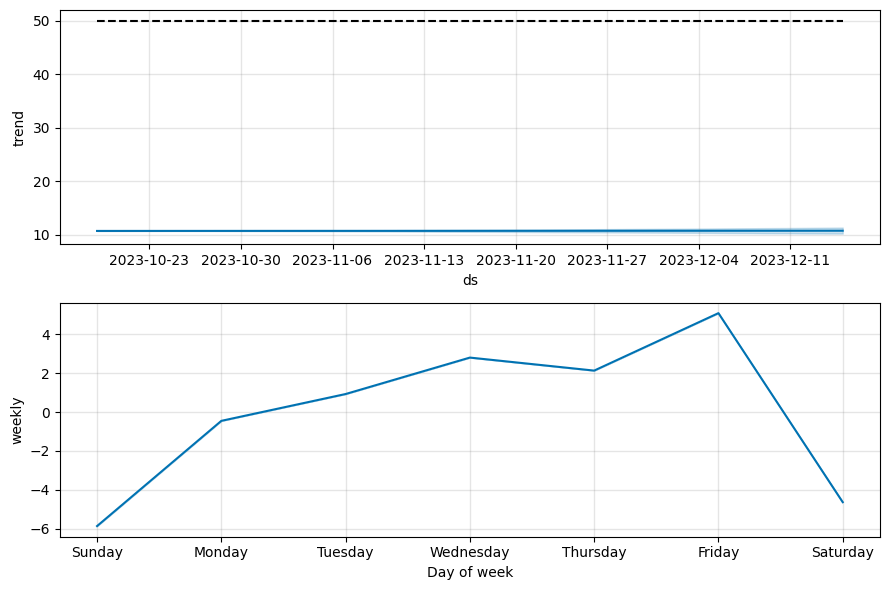

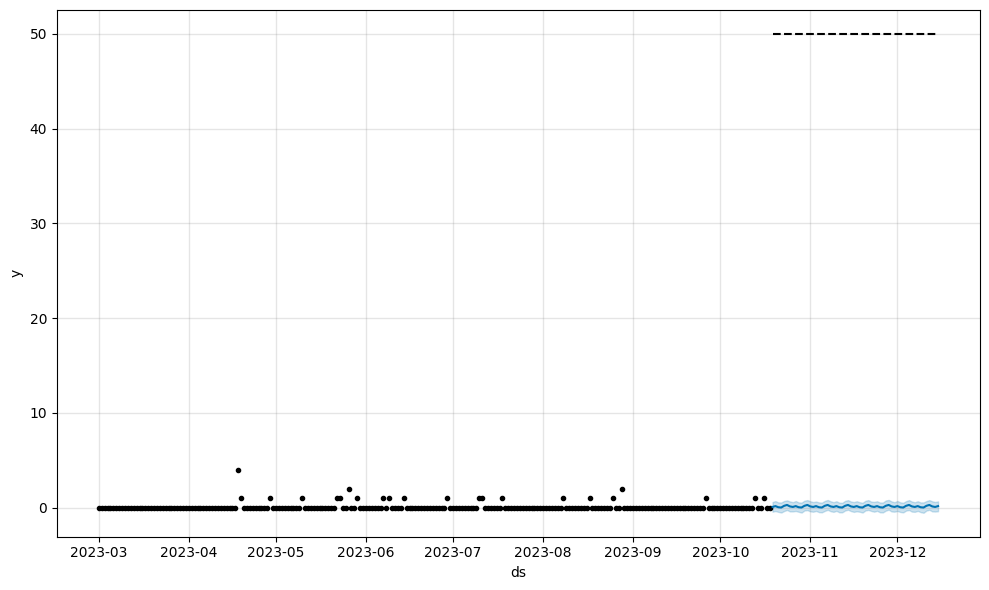

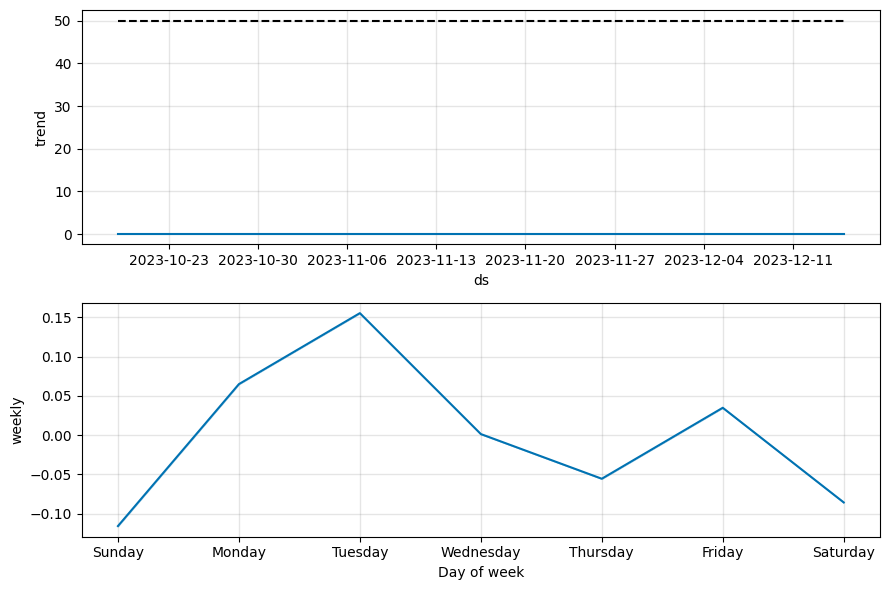

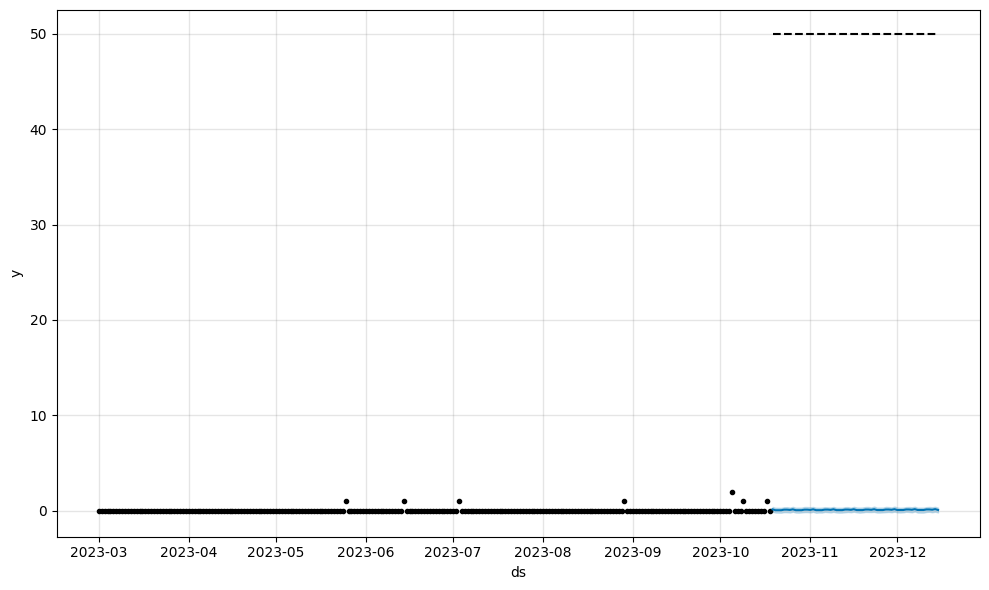

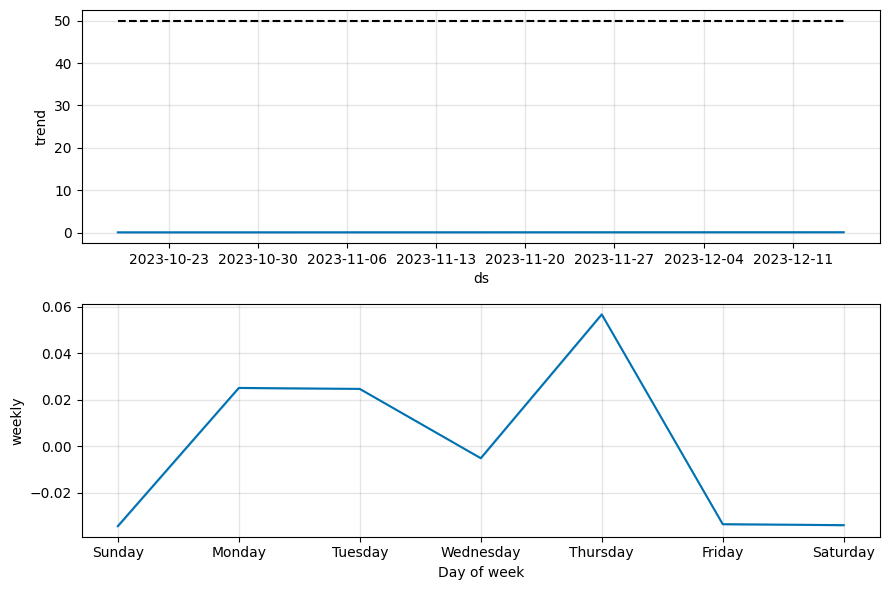

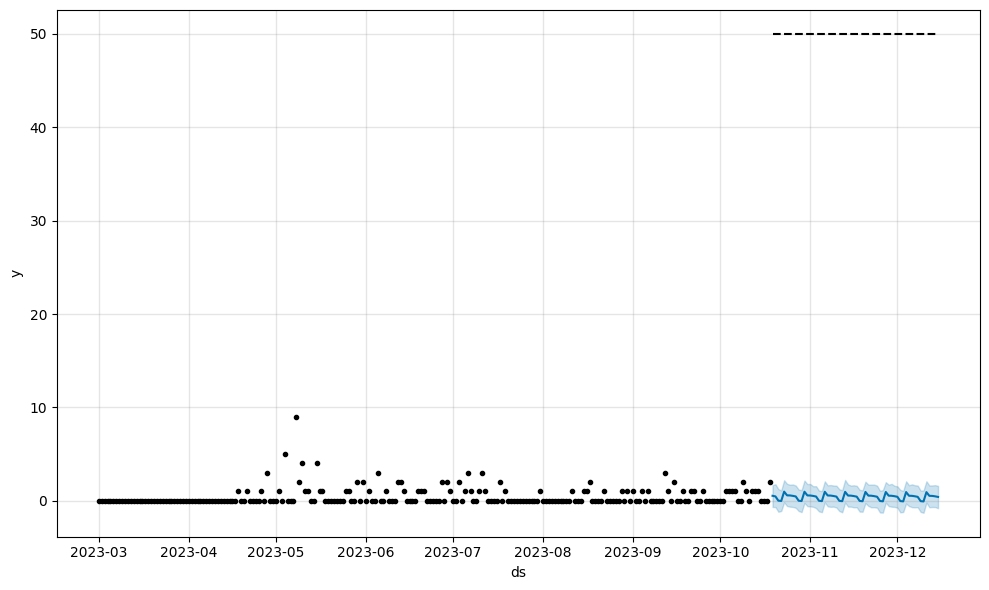

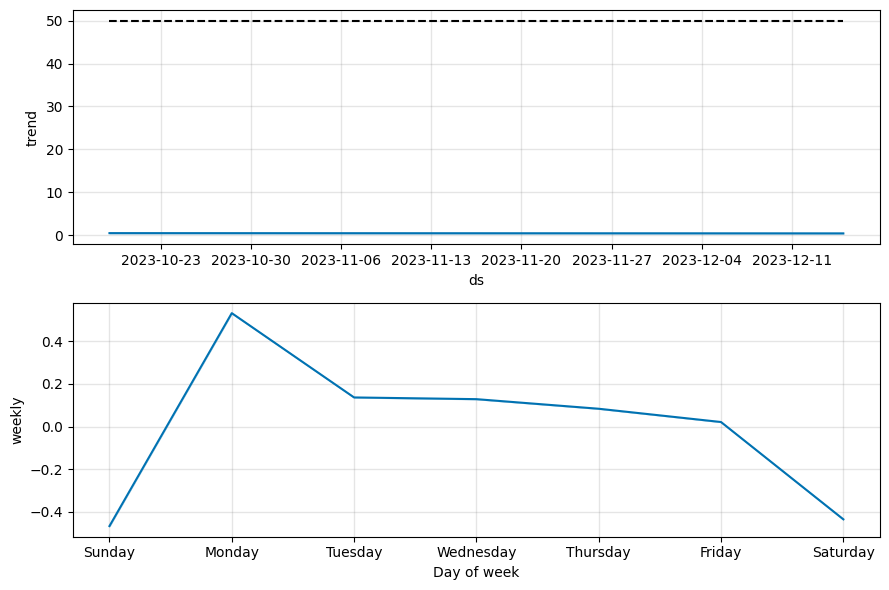

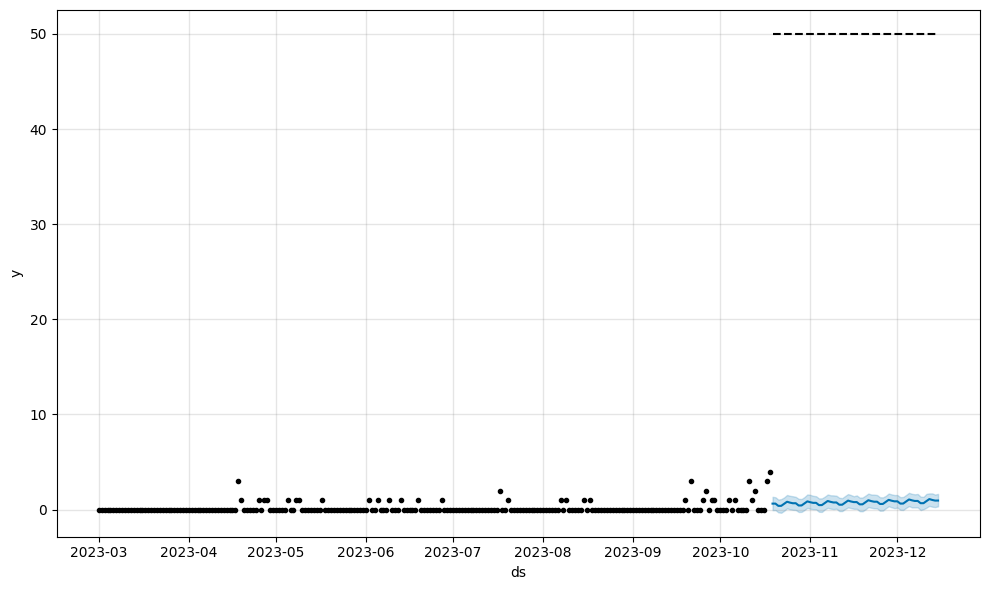

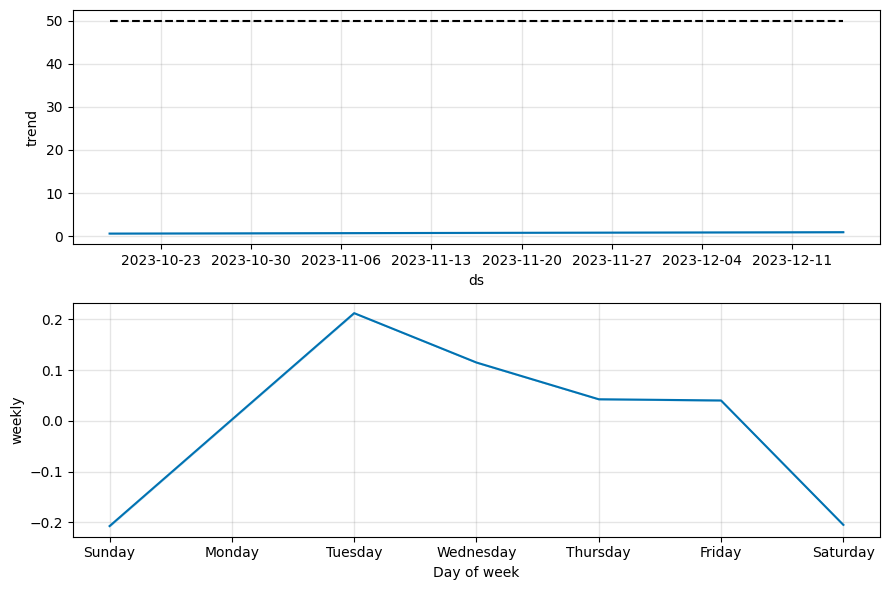

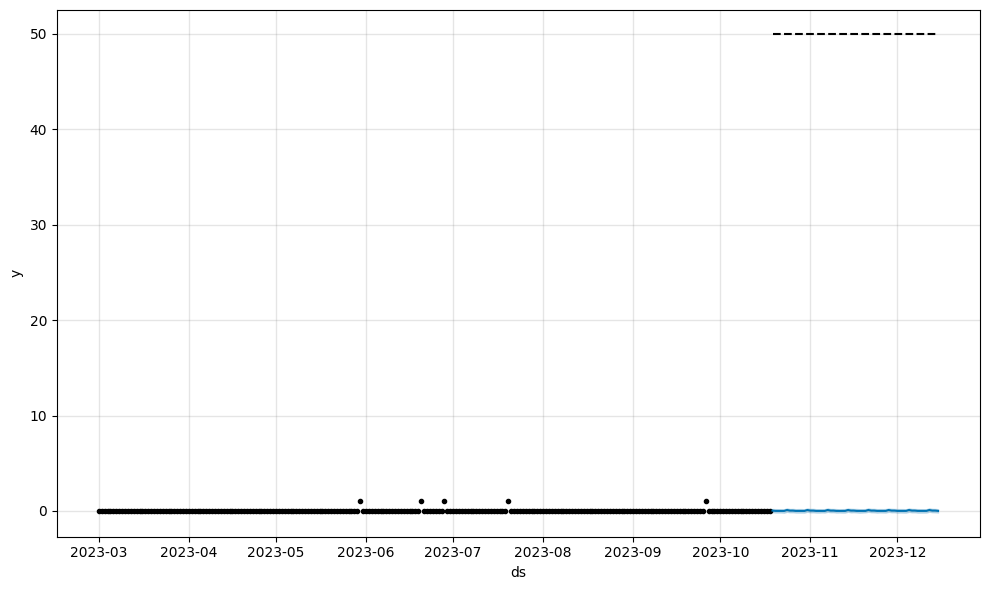

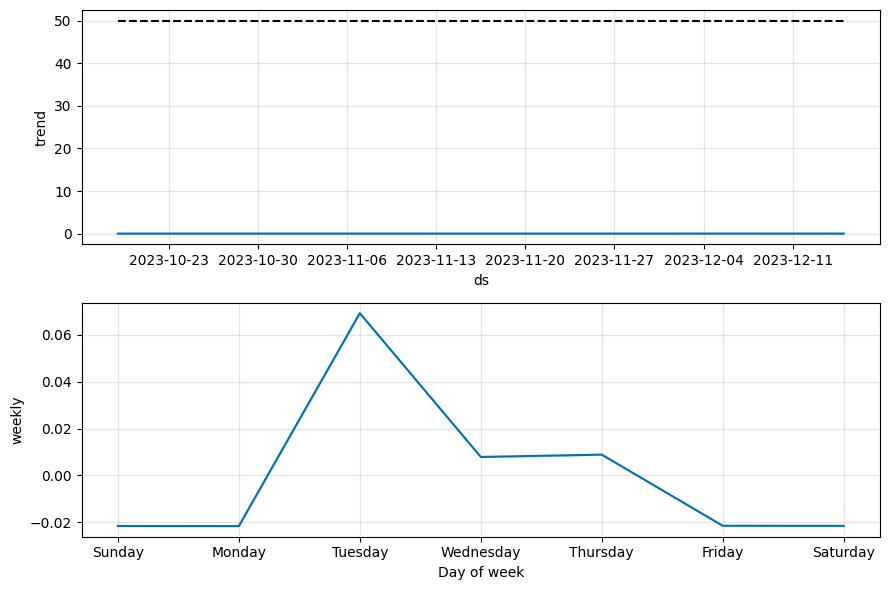

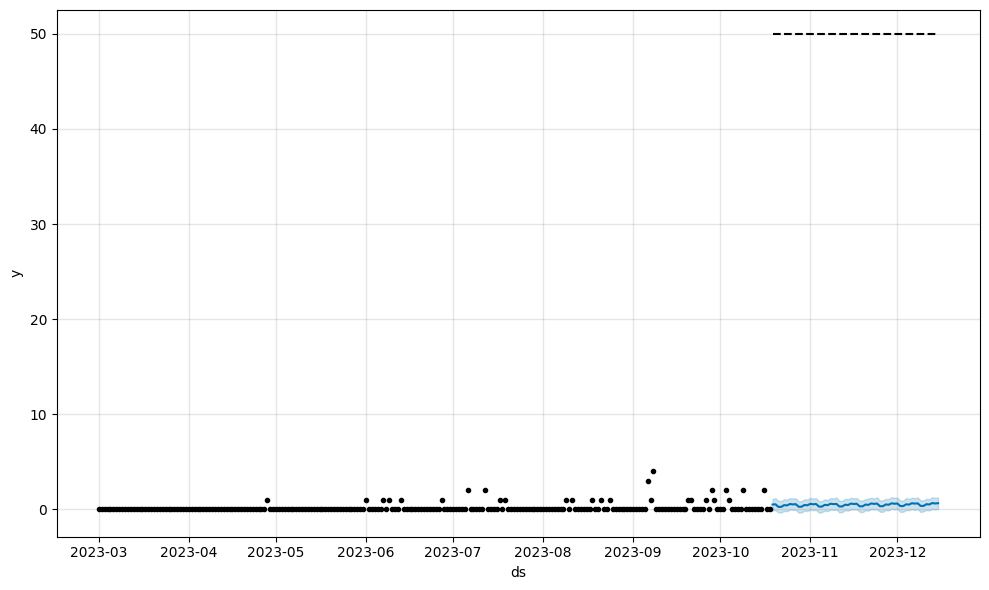

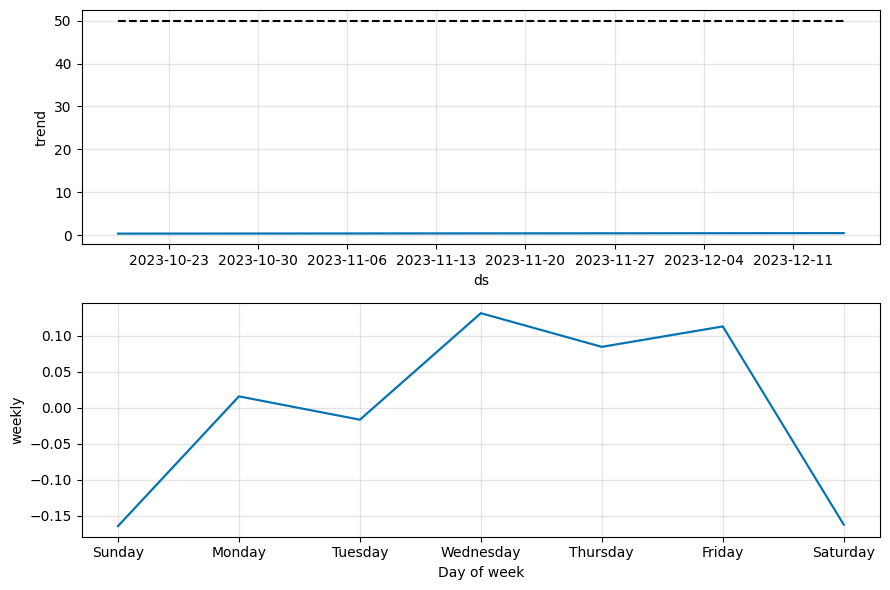

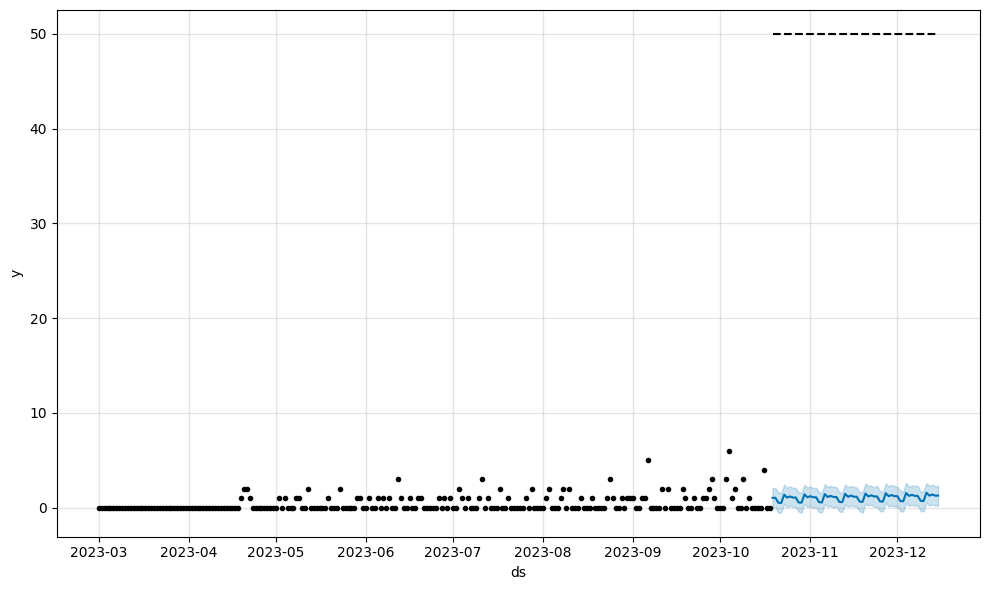

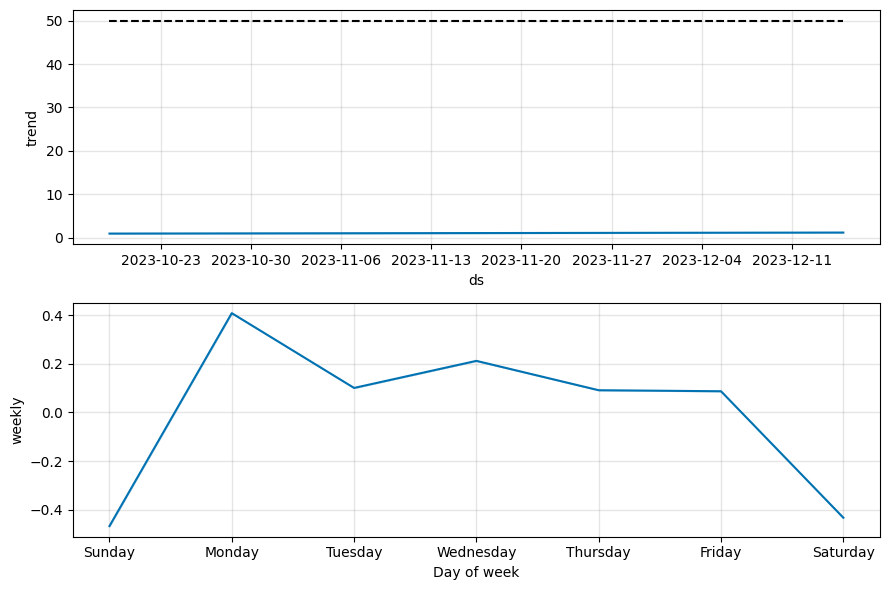

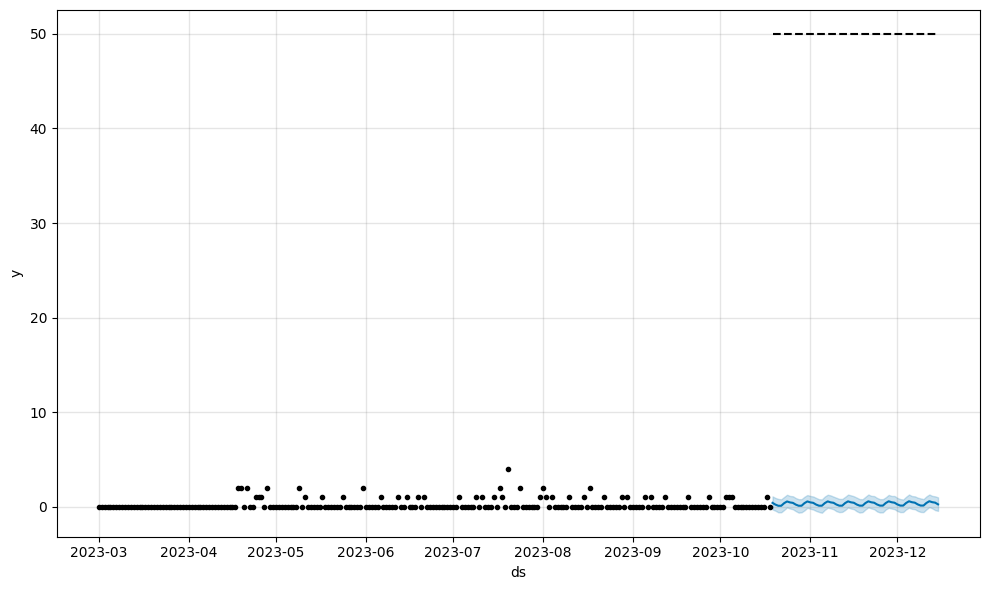

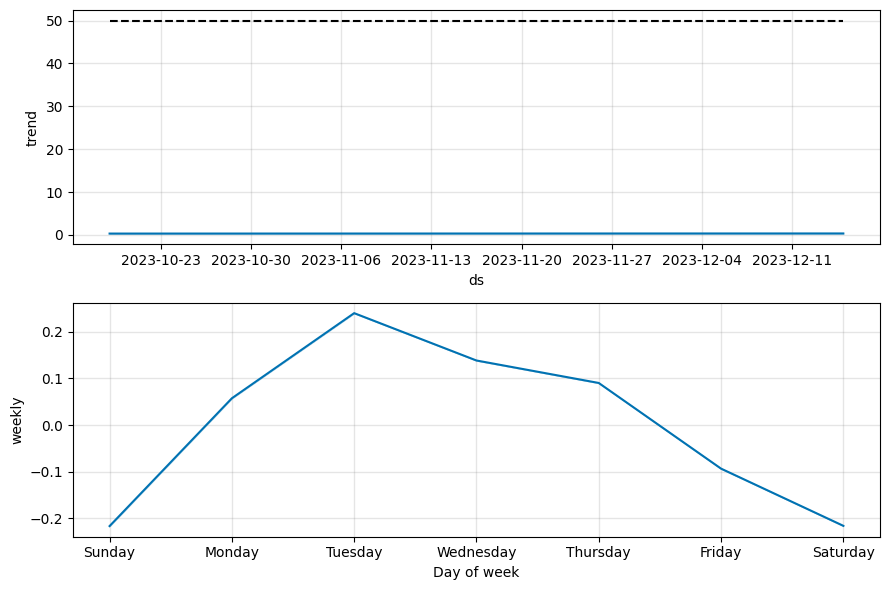

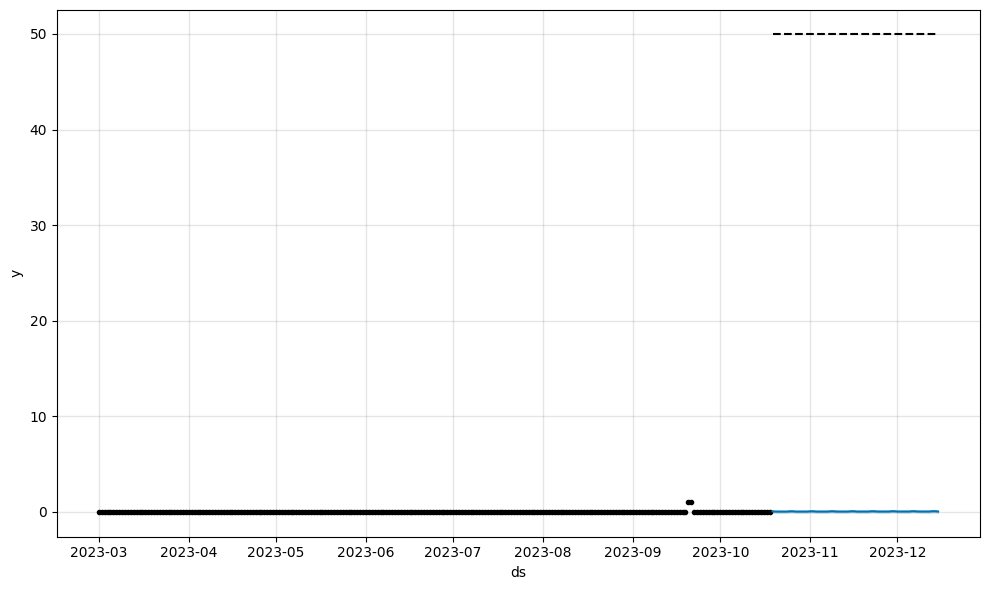

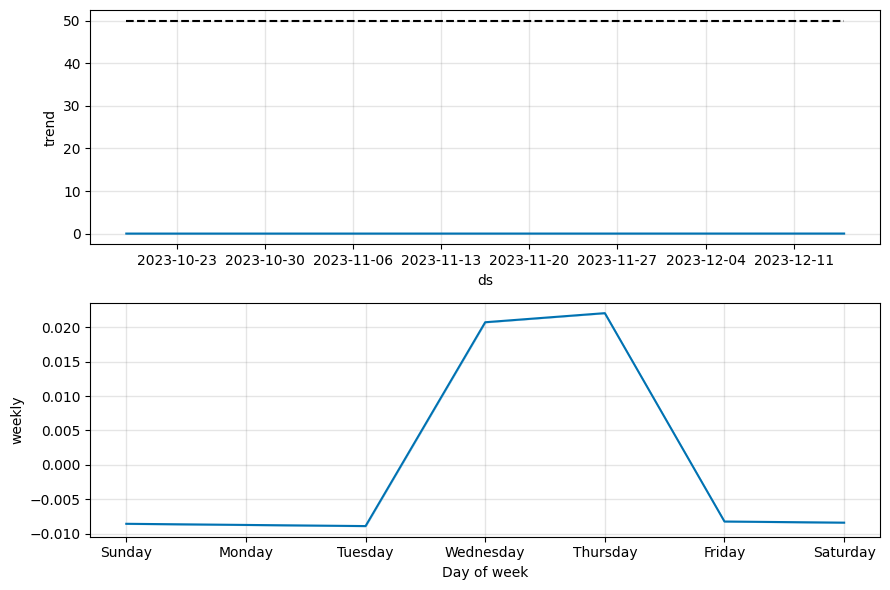

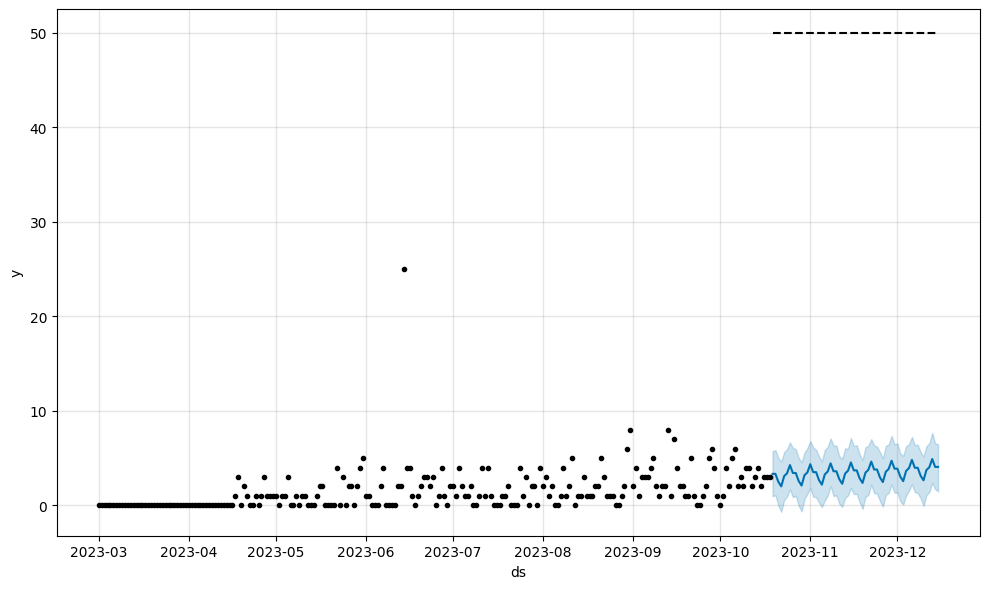

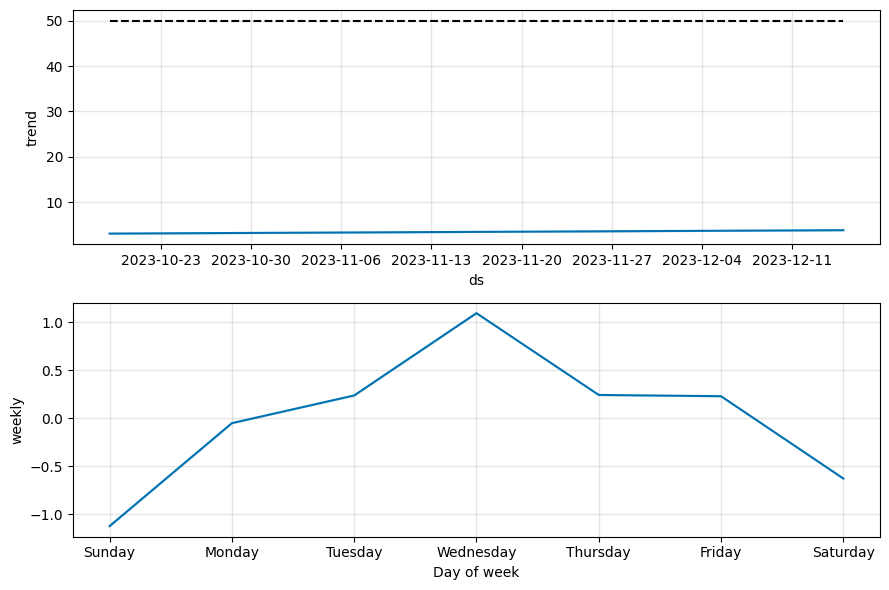

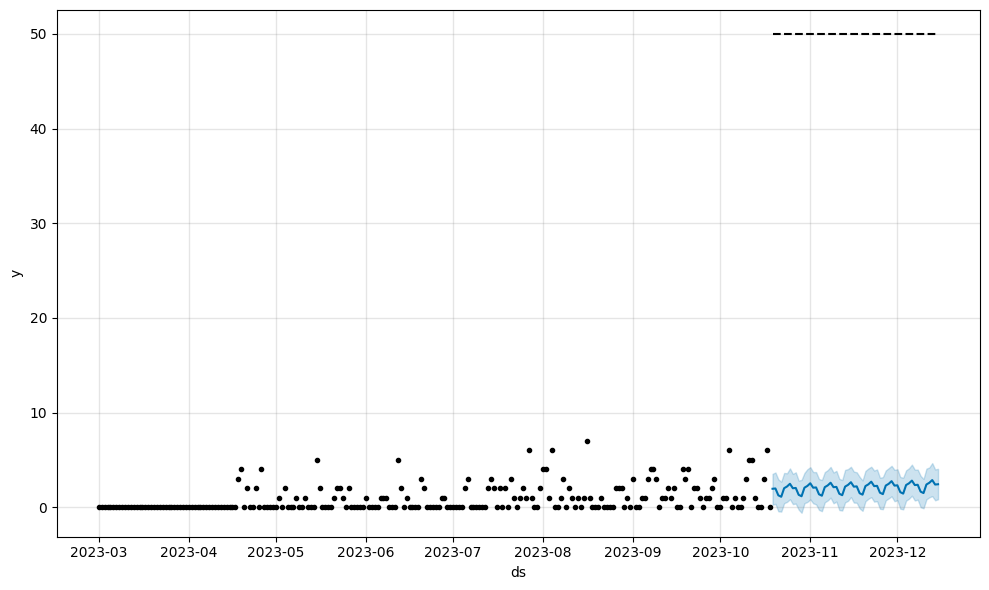

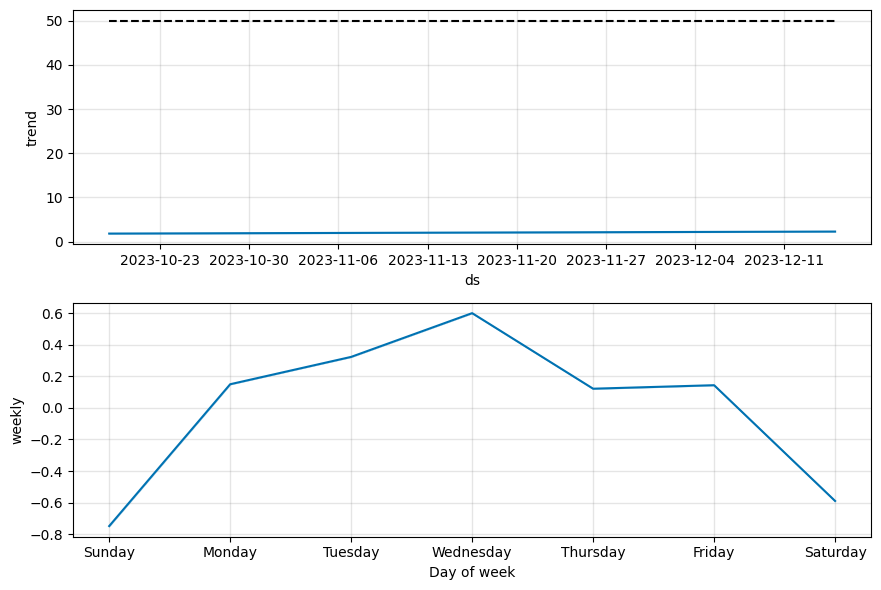

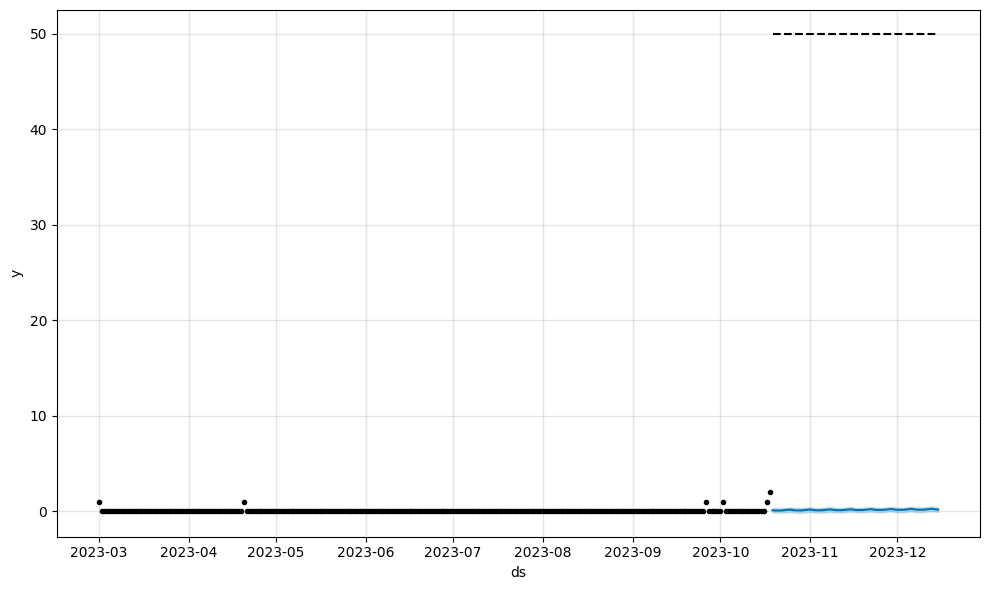

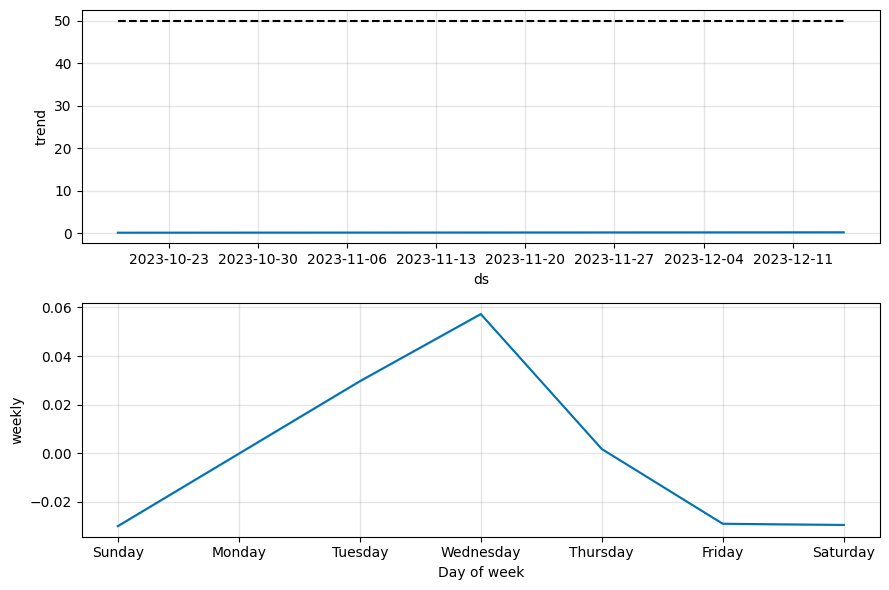

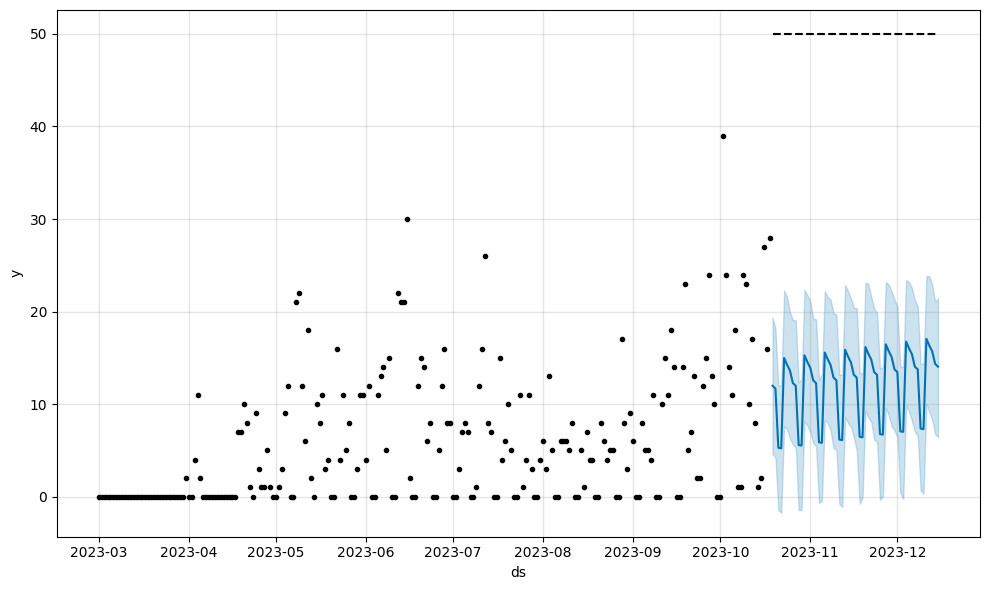

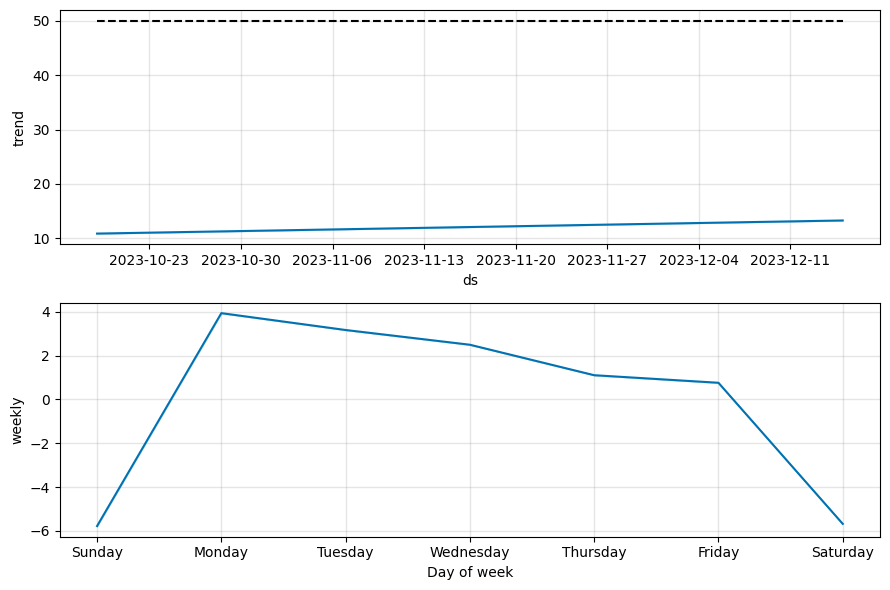

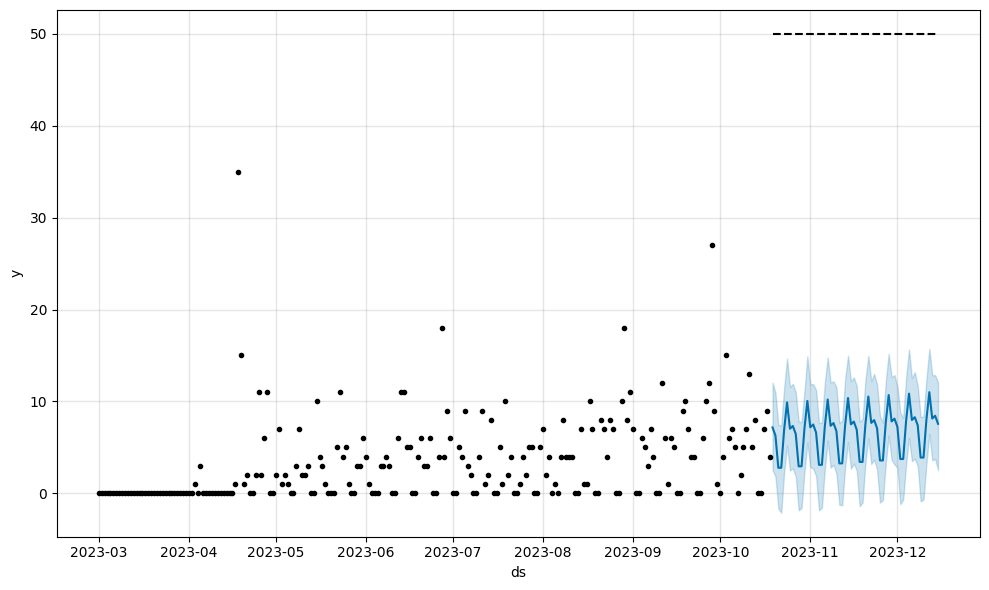

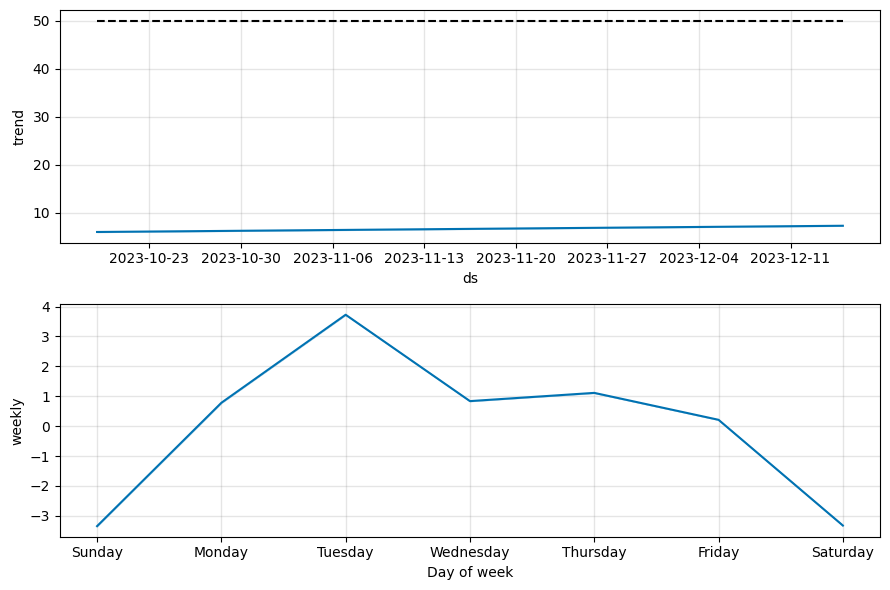

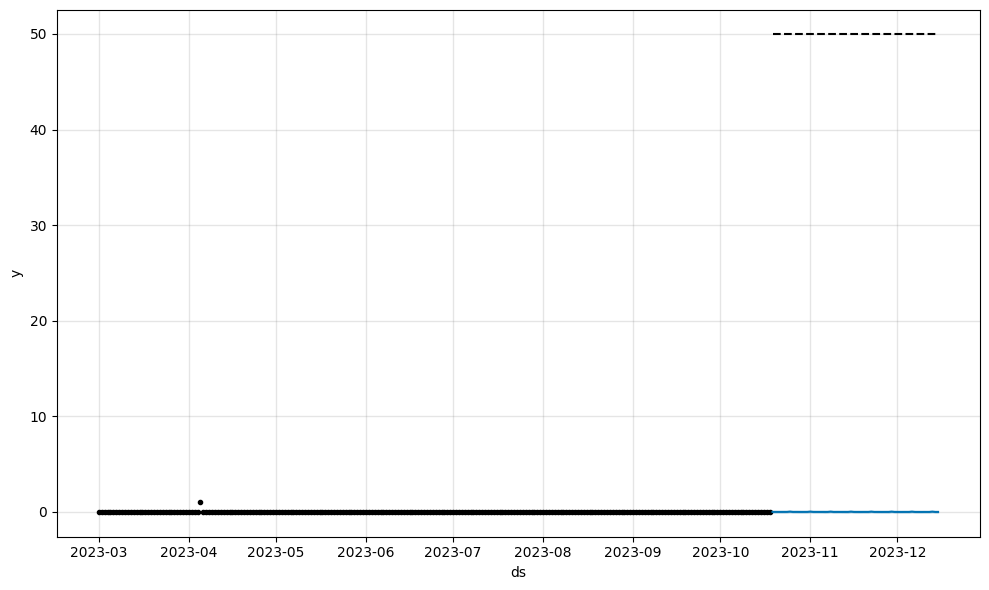

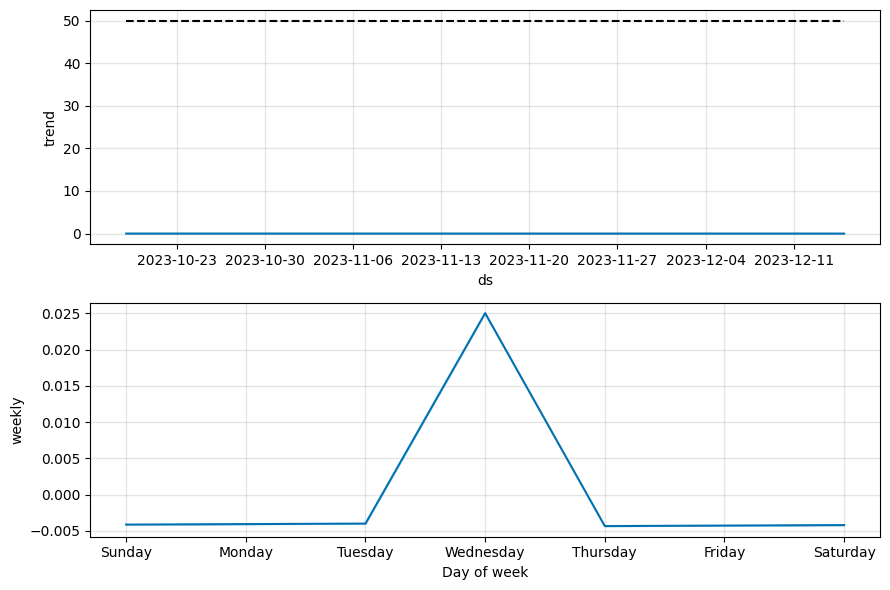

In [41]:
models_list=models_list_priority_category_wise
forecast_list=forecast_list_priority_category_wise
for i in range(len(models_list)):
    print(i)
    models_list[i].plot(forecast_list[i])
    models_list[i].plot_components(forecast_list[i])